Import dependencies

In [1]:
from model.layers import GraphSpectralFilterLayer, AnalysisFilter
from model.spectral_filter import Graph
import torch
import torch.nn.functional as F
from torch import nn
from random import seed as rseed
from numpy.random import seed as nseed
from citation import get_dataset, random_planetoid_splits, run
from citation.train_eval import evaluate
import numpy as np


Define hyperparameters

In [2]:
dataset_name = 'Cora'

random_splits = False
runs = 1
epochs =300
alpha = 0.2
seed =729
lr =0.001
weight_decay = 0.00012376256876336363
patience=10
hidden=56
heads =10
output_heads =10
dropout=0.7
normalize_features = True
pre_training = False
cuda = False
chebyshev_order =16
edge_dropout =0
node_feature_dropout =0
filter_name ='analysis'

rseed(seed)
nseed(seed)
torch.manual_seed(seed)

cuda = cuda and torch.cuda.is_available()

if cuda:
    torch.cuda.manual_seed(seed)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    
def get_correctly_predicted_node_idx(net, key, dataset):
    net.eval()
    with torch.no_grad():
        logits  = net(dataset[0])[0]
    mask = dataset[0]['{}_mask'.format(key)]
    pred = logits[mask].max(1)[1]
    return { *pred.eq(dataset[0].y[mask]).nonzero().view(-1).tolist() }

In [3]:
def matching_labels_distribution(nodes_set):
    hop_1_matching_percent = []
    hop_2_matching_percent = []
    hop_3_matching_percent = []
    for n in nodes_set:
        hop_1_neighbours = list(nx.ego_graph(G, n.item(), 1).nodes())
        hop_2_neighbours = list(nx.ego_graph(G, n.item(), 2).nodes())
        hop_3_neighbours = list(nx.ego_graph(G, n.item(), 3).nodes())
        node_label = dataset[0].y[n]
        hop_1_labels = dataset[0].y[hop_1_neighbours]
        hop_2_labels = dataset[0].y[hop_2_neighbours]
        hop_3_labels = dataset[0].y[hop_3_neighbours]
        matching_1_labels = node_label == hop_1_labels
        matching_2_labels = node_label == hop_2_labels
        matching_3_labels = node_label == hop_3_labels
        hop_1_matching_percent.append(matching_1_labels.float().sum()/matching_1_labels.shape[0])
        hop_2_matching_percent.append(matching_2_labels.float().sum()/matching_2_labels.shape[0])
        hop_3_matching_percent.append(matching_3_labels.float().sum()/matching_3_labels.shape[0])


    print('matching labels in 1st hop:', torch.tensor(hop_1_matching_percent).mean())
    print('matching labels in 2st hop:', torch.tensor(hop_2_matching_percent).mean())
    print('matching labels in 3rd hop:', torch.tensor(hop_3_matching_percent).mean())
    plt.figure(figsize=(15,3))
    plt.subplot(1, 3, 1)
    plt.hist(hop_1_matching_percent, color = 'blue', edgecolor = 'black', bins = 10)
    plt.subplot(1, 3, 2)
    plt.hist(hop_2_matching_percent, color = 'blue', edgecolor = 'black', bins = 10)
    plt.subplot(1, 3, 3)
    plt.hist(hop_2_matching_percent, color = 'blue', edgecolor = 'black', bins = 10)
    return hop_1_matching_percent, hop_2_matching_percent, hop_3_matching_percent


Define model

In [4]:
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        data = dataset.data
        adj = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.num_edges))
        self.G = Graph(adj)
        self.G.estimate_lmax()

        self.analysis = GraphSpectralFilterLayer(self.G, dataset.num_node_features, hidden,
                                                 dropout=dropout, out_channels=heads, filter=filter_name,
                                                 pre_training=False, device='cuda' if cuda else 'cpu',
                                                 alpha=alpha, chebyshev_order=chebyshev_order, concat=True)

        self.synthesis = GraphSpectralFilterLayer(self.G, hidden * heads, dataset.num_classes, filter=filter_name,
                                                  device='cuda' if cuda else 'cpu', dropout=dropout,
                                                  out_channels=output_heads, alpha=alpha, pre_training=False,
                                                  chebyshev_order=chebyshev_order, concat=False)

    def reset_parameters(self):
        self.analysis.reset_parameters()
        self.synthesis.reset_parameters()

    def forward(self, data):
        x = data.x
        x = F.dropout(x, p=dropout, training=self.training)
        x, att1 = self.analysis(x)
        x = F.dropout(x, p=dropout, training=self.training)
        x, att2 = self.synthesis(x)
        x = F.elu(x)
        return F.log_softmax(x, dim=1), att1, att2


dataset = get_dataset(dataset_name, normalize_features, edge_dropout=edge_dropout,
                                node_feature_dropout=node_feature_dropout)

if cuda:
    dataset[0].to('cuda')

In [5]:
class SingleNet(torch.nn.Module):
    def __init__(self, dataset):
        super(SingleNet, self).__init__()
        data = dataset[0]
        adj = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.num_edges))
        self.G = Graph(adj)
        self.G.estimate_lmax()

        self.analysis = GraphSpectralFilterLayer(self.G, dataset.num_node_features, hidden,
                                                 dropout=dropout, out_channels=heads, filter=filter_name,
                                                 pre_training=pre_training, device='cuda' if cuda else 'cpu',
                                                 alpha=alpha, chebyshev_order=chebyshev_order)

        self.W = torch.nn.Parameter(torch.zeros(hidden * heads, dataset.num_classes))

    def reset_parameters(self):
        self.analysis.reset_parameters()
        torch.nn.init.xavier_uniform_(self.W.data, gain=1.414)

    def forward(self, data):
        x = data.x
        x = F.dropout(x, p=dropout, training=self.training)
        x, attentions_1 = self.analysis(x)
        x = F.dropout(x, p=dropout, training=self.training)
        x = F.elu(x.mm(self.W))
        return F.log_softmax(x, dim=1), attentions_1, None

Load trained model and evaluate

In [6]:
model = Net(dataset)
model.load_state_dict(torch.load('./model/best_{}_10_heads.pkl'.format(dataset_name),  map_location={'cuda:0': 'cpu'}))

# model = SingleNet(dataset)
# model.load_state_dict(torch.load('./model/best_{}_single_layer.pkl'.format(dataset_name)))

filter_kernel = model.analysis.filter_kernel

# model_correct_indices = get_correctly_predicted_node_idx(model, 'test', dataset)
eval_info = evaluate(model, dataset[0])
print(eval_info)

{'train_loss': 0.2274864912033081, 'train_acc': 0.9395695364238411, 'train_micro_f1_score': 0.9395695364238411, 'train_macro_f1_score': 0.9372823421644033, 'val_loss': 0.39523881673812866, 'val_acc': 0.874, 'val_micro_f1_score': 0.874, 'val_macro_f1_score': 0.8693688497830661, 'test_loss': 0.39944887161254883, 'test_acc': 0.881, 'test_micro_f1_score': 0.881, 'test_macro_f1_score': 0.8714944907536788}


Obtain attention weights in layer 1 and 2

In [10]:
with torch.no_grad():
    _, att1, att2 = model(dataset[0])
model_att1_sum = torch.stack(att1).sum(dim=0)

RuntimeError: stack expects a non-empty TensorList

In [66]:
for i in range(heads):
    print(att1[i][(att1[i].bool().float() - torch.eye(att1[i].shape[0], att1[i].shape[1])).nonzero(as_tuple=True)].mean())

tensor(0.0253)
tensor(0.0253)
tensor(4.2710e-06)
tensor(0.0253)
tensor(3.3296e-06)
tensor(0.0253)
tensor(0.0253)
tensor(0.0253)
tensor(1.8445e-07)
tensor(2.8902e-06)
tensor(0.0253)
tensor(2.1056e-06)


Build NetworkX Graph

In [11]:
import networkx as nx
from scipy.sparse import coo_matrix
import numpy as np

# Build graph
adj = coo_matrix(
    (np.ones(dataset[0].num_edges),
    (dataset[0].edge_index[0].numpy(), dataset[0].edge_index[1].numpy())),
    shape=(dataset[0].num_nodes, dataset[0].num_nodes))
G = nx.Graph(adj)


In [12]:
from matplotlib import pyplot as plt
def plot_filter_banks(idx=list(range(heads)), kernel=model.analysis.filter._kernel, ax=None, no_ticks=False, legend=True):
    x = torch.linspace(0, 2, 100)
    if no_ticks:
        plt.xticks([])
        plt.yticks([])
    if not ax:
        plt.figure()
        plt.plot(x, kernel(x).detach()[:, idx])
#         if len(idx) > 1 and legend:
#             plt.legend(['filter {}'.format(i) for i in range(1, len(idx) + 1)])
        plt.show()
    else:
        ax.plot(x, kernel(x).detach()[:, idx])
#         if len(idx) > 1 and legend:
#             ax.legend(['filter {}'.format(i) for i in range(1, len(idx) + 1)])

Plot filterbanks in layer 1 and 2

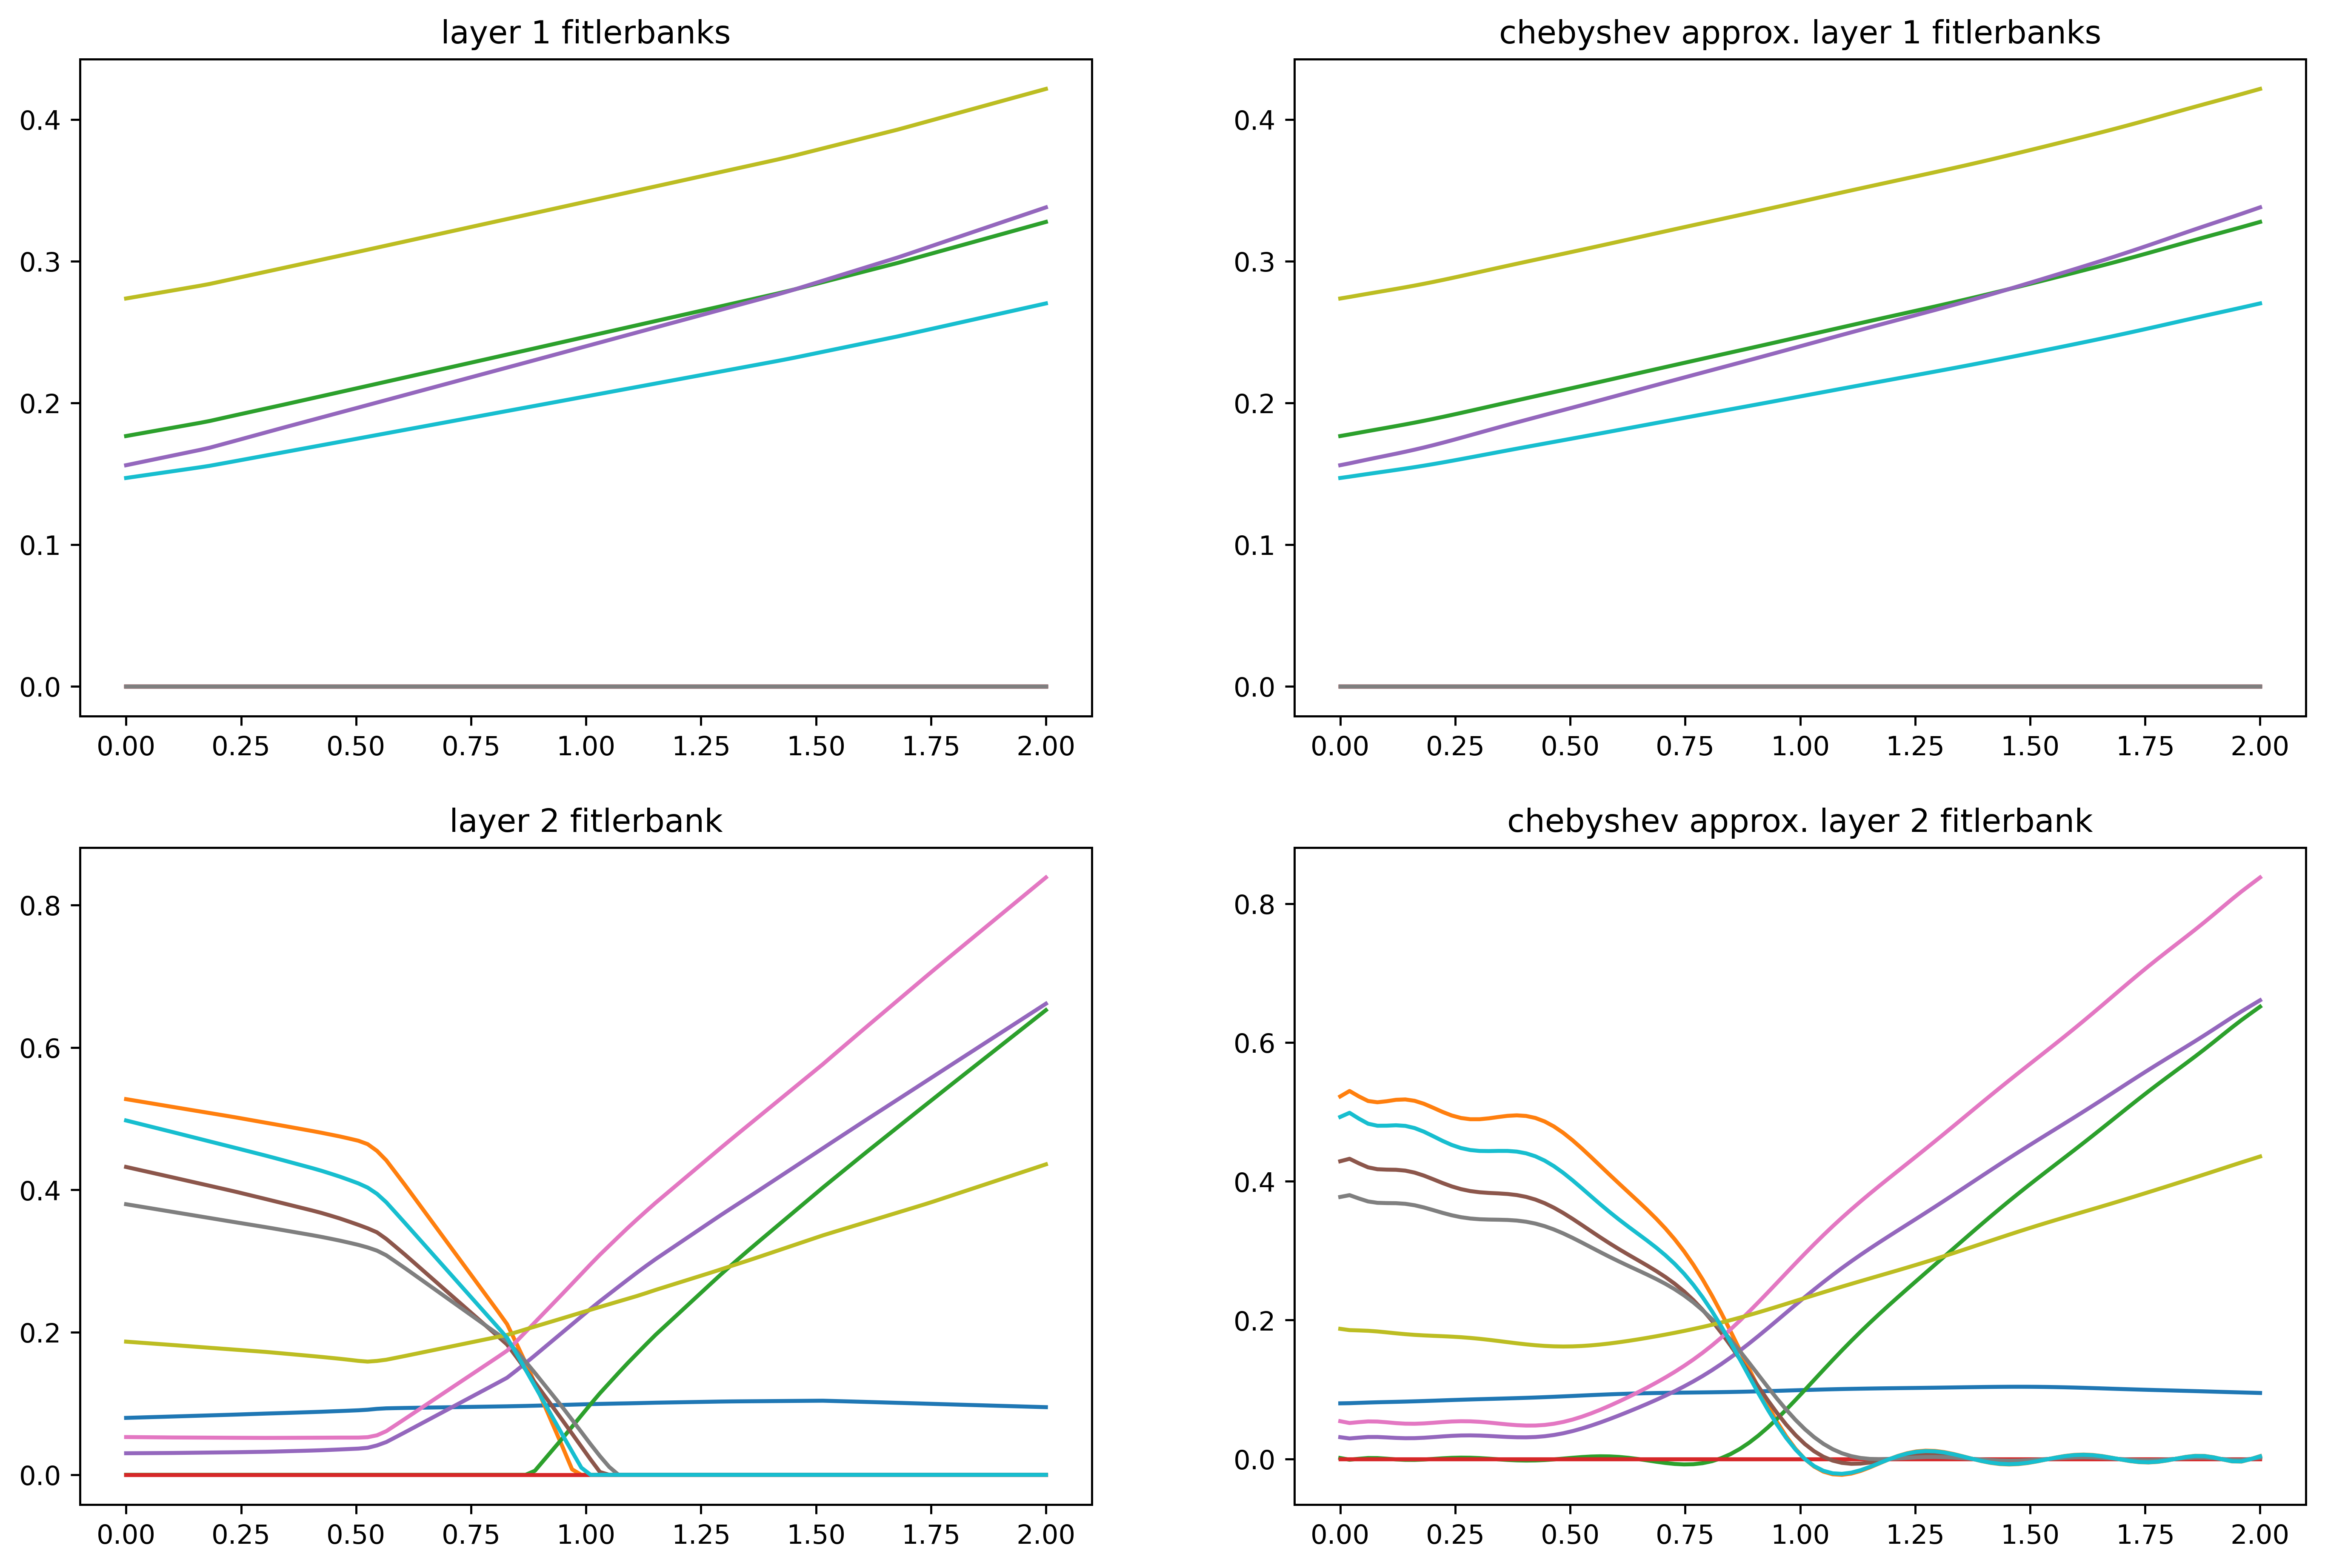

In [14]:
plt.figure(figsize=(15,10), dpi=450)
ax1 = plt.subplot(2, 2, 1)
ax1.set_title('layer 1 fitlerbanks')
plot_filter_banks(kernel=model.analysis.filter._kernel, ax=ax1)
ax2 = plt.subplot(2, 2, 2)
ax2.set_title('chebyshev approx. layer 1 fitlerbanks')
plot_filter_banks(kernel=model.analysis.filter.cheby_eval, ax=ax2)

if hasattr(model, 'synthesis'):
    ax3 = plt.subplot(2, 2, 3)
    ax3.set_title('layer 2 fitlerbank')
    plot_filter_banks(kernel=model.synthesis.filter._kernel, ax=ax3, legend=False)
    ax4 = plt.subplot(2, 2, 4)
    ax4.set_title('chebyshev approx. layer 2 fitlerbank')
    plot_filter_banks(kernel=model.synthesis.filter.cheby_eval, ax=ax4, legend=False)

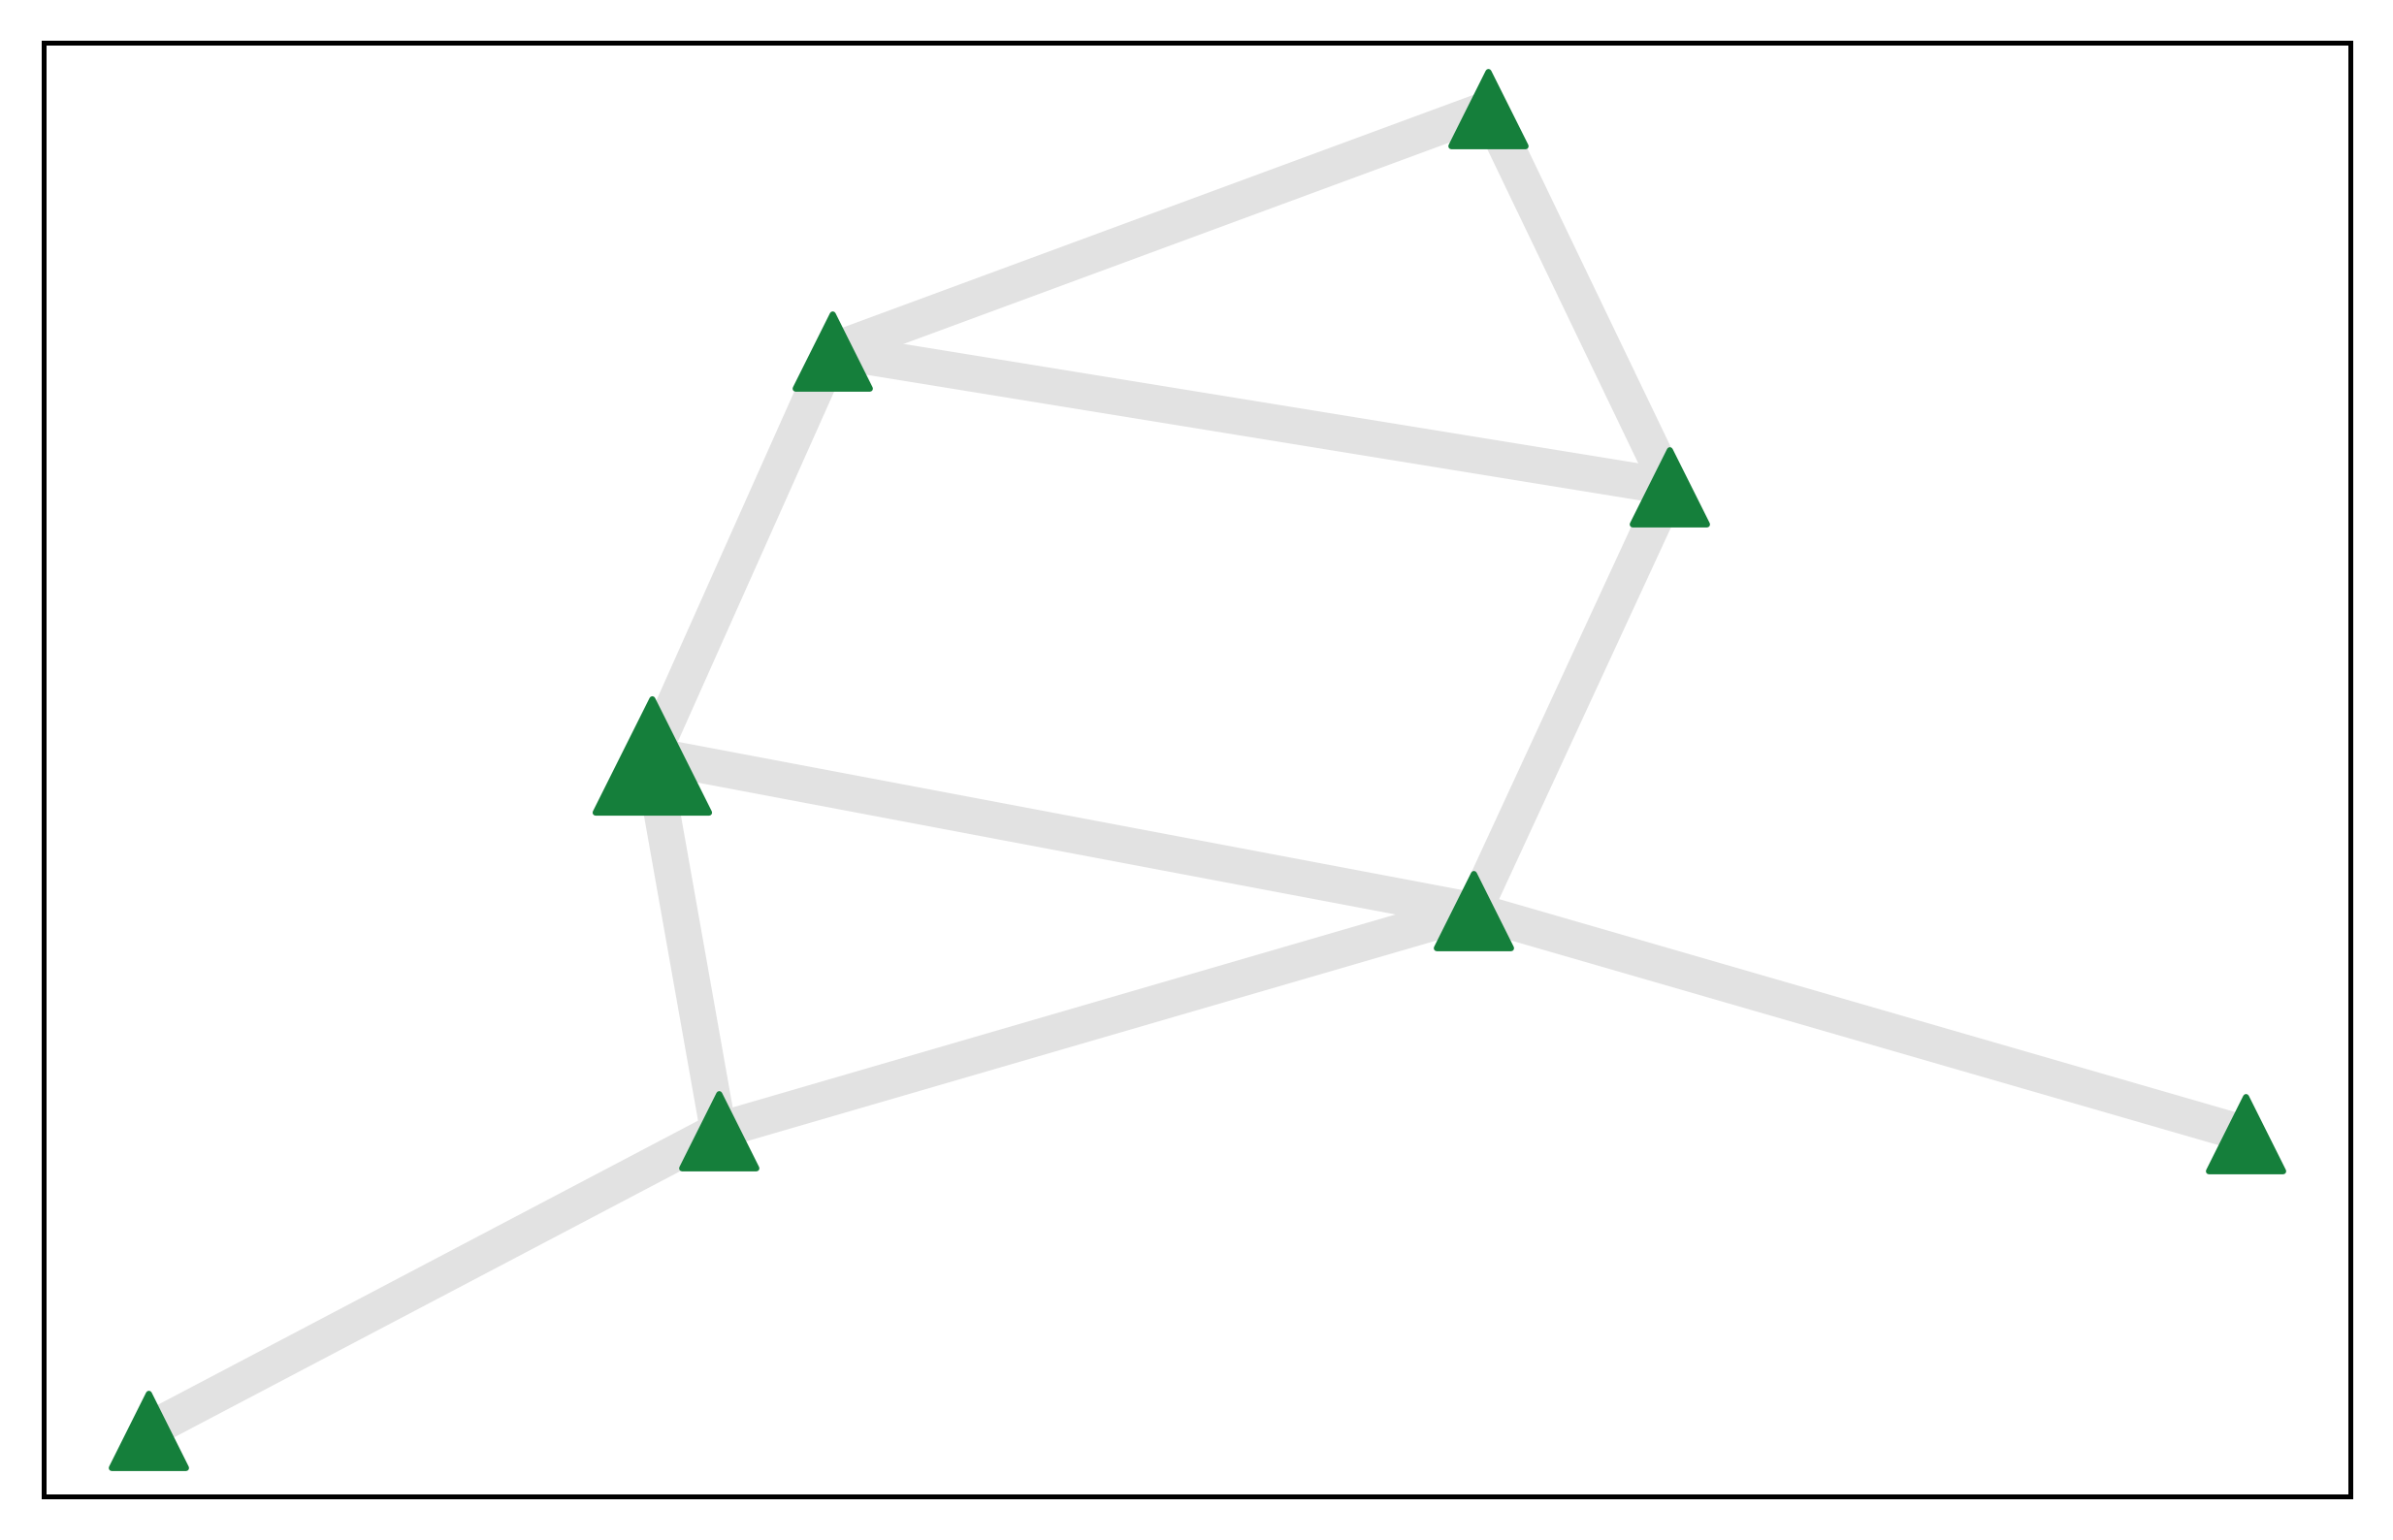

In [15]:
node = 0
# node = model_not_gat_correct_nodes[1].item()
Gego = nx.ego_graph(G, node, 2)
nodePos = nx.layout.kamada_kawai_layout(Gego)

node_colors = {
   0: plt.cm.Reds, 1: plt.cm.Oranges, 2: plt.cm.RdPu, 
   3: plt.cm.Greens, 4: plt.cm.Greys, 5: plt.cm.Purples, 
}
node_shapes={0: '8', 1: 'o', 2: 'd', 3: '^', 4: 's', 5: '*'}



plt.figure(figsize=(15,15), dpi=450);
# plt.figure(figsize=(15,15));

ax = plt.subplot(3, 2, 1)
                 

for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           nodelist=[n],
                           node_color=[node_colors[dataset[0].y[n].item()](0.8)],
                           node_shape=node_shapes[dataset[0].y[n].item()],
                           node_size=350 if n == node else 150,
                           ax=ax)
nx.draw_networkx_edges(Gego, nodePos,
#                            edgelist=[*[(node, n) for n in nodes], ],
                           edgelist= Gego.edges,
#                            width=[5 if e in edges else 2 for e in Gego.edges],
                           width=6,
#                            edge_color=[plt.cm.Greys(0.8) if e in edges else plt.cm.Greys(0.2) for e in Gego.edges],
                           edge_color=plt.cm.Greys(0.2),
                           ax=ax)

# for j in G.nodes:
#     a = None
#     for i in range(len(att1)):
#     #     plt.figure(figsize=(15,5), dpi=450)
# #         plt.figure(figsize=(15,5));

#         att = att1[i]
#         if a is None and len((att[j] > 0.001).nonzero().view(-1).tolist()) != 1:
#             a = len((att[j] > 0.0001).nonzero().view(-1).tolist())
#         else:
#             if a is not None and np.abs(a - len((att[j] > 0.001).nonzero().view(-1).tolist())) > 3 and len((att[j] > 0.001).nonzero().view(-1).tolist()) != 1:
#                 if nx.single_source_shortest_path_length(G, j) > 1:
#                     print(j)
#                     print(i, a, len((att[j] > 0.001).nonzero().view(-1).tolist()))


In [16]:

node=269
# # node=4
# # node = model_not_gat_correct_nodes[1].item()
Gego = nx.ego_graph(G, node, 2)
nodePos = nx.layout.kamada_kawai_layout(Gego)
node_colors = {
   0: plt.cm.Reds, 1: plt.cm.Oranges, 2: plt.cm.RdPu, 
   3: plt.cm.Greens, 4: plt.cm.Greys, 5: plt.cm.Purples, 
}
node_shapes={0: '8', 1: 'o', 2: 'd', 3: '^', 4: 's', 5: '*'}



# for n in Gego.nodes:
#     nx.draw_networkx_nodes(Gego, nodePos,
#                            nodelist=[n],
#                            node_color=[node_colors[dataset[0].y[n].item()](0.8)],
#                            node_shape="*" if n == node else node_shapes[dataset[0].y[n].item()],
#                            node_size=350 if n == node else 80)
# nx.draw_networkx_edges(Gego,nodePos, width=2, alpha=0.4)
for i in range(heads):
# for i in [0, 2, 3, 10]:
# for i in [3]:
    Gego = nx.ego_graph(G, node, 2)
    att = att1[i]
    nodes = (att[node] > 0.0000).nonzero().view(-1).tolist()
    print(i, len(nodes))
#     plt.figure(figsize=(15,5), dpi=450);
#     ax = plt.subplot(1, 2, 1)
#     plot_filter_banks(idx=[i], ax=ax, no_ticks=True)

    ax = plt.subplot(1, 2, 2)
#     for n in Gego.nodes:
    for n in nodes:
        nx.draw_networkx_nodes(Gego, nodePos,
                               nodelist=[n],
                               ax=ax,
                               node_color=[node_colors[dataset[0].y[n].item()](0.7)],
                               node_shape=node_shapes[dataset[0].y[n].item()],
                               node_size=300 if n == node else 150,
#                                node_size=300 if n == node else (torch.exp(att[node, n])*100).clamp(max=300, min=50),
#                                node_size=300 if n == node else 200
                              )
#     edges = list(filter(lambda e: e[0] in nodes and e[1] in nodes, list(Gego.edges)))
#     nx.draw_networkx_edges(Gego, nodePos,
# #                            edgelist=[*[(node, n) for n in nodes], ],
#                            edgelist= Gego.edges,
# #                            width=[5 if e in edges else 2 for e in Gego.edges],
#                            width=7,
# #                            edge_color=[plt.cm.Greys(0.8) if e in edges else plt.cm.Greys(0.2) for e in Gego.edges],
#                            edge_color=plt.cm.Greys(0.2),
#                            alpha=0.4,
#                            ax=ax)
#     nx.draw_networkx_edges(Gego, nodePos,
#                            edgelist=[*[(n, node) for n in nodes], ],
# #                            edgelist= Gego.edges,
# #                            width=[5 if e in edges else 2 for e in Gego.edges],
#                            width=1.5,
#                            style="dashed",
# #                            edge_color=[plt.cm.Greys(0.8) if e in edges else plt.cm.Greys(0.2) for e in Gego.edges],
# #                            alpha=0.5,
#                            edge_color=plt.cm.Greys(0.4),
#                            arrows=True,
#                            ax=ax)
    Gego = nx.DiGraph(Gego)
    nx.draw_networkx_edges(Gego, nodePos,
                           edgelist=[*[(n, node) for n in nodes], ],
#                            edgelist= Gego.edges,
#                            width=[5 if e in edges else 2 for e in Gego.edges],
                           width=4,
#                            edge_color=[plt.cm.Greys(0.8) if e in edges else plt.cm.Greys(0.2) for e in Gego.edges],
                           alpha=0.3,
                           edge_color=plt.cm.Blues(0.8),
                           connectionstyle='arc3,rad=0.1',
                           arrows=True,
                           ax=ax)
    plt.show();


IndexError: list index out of range

### Frequency cutoff analysis

In [19]:
# Cut frequency bands abruptly
class CutOff(nn.Module):
    def __init__(self, kernel, min_val = 0, max_val = 2):
        super(CutOff, self).__init__()
        self.min = min_val
        self.max = max_val
        self.kernel = kernel

    def reset_parameters(self):
        pass

    def forward(self, x):
        h = torch.where(x.view(-1,1).repeat(1, heads) < self.min, torch.zeros(x.shape[0], heads), self.kernel(x))
        h = torch.where(x.view(-1,1).repeat(1, heads) > self.max, torch.zeros(x.shape[0], heads), h)
        return h

Evaluate low pass cutoff

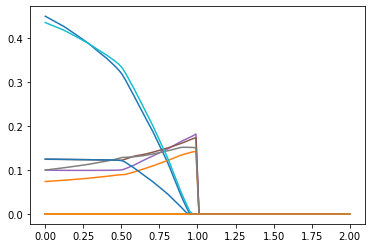

{'train_loss': 0.29327070713043213, 'train_acc': 0.9147350993377483, 'val_loss': 0.45016029477119446, 'val_acc': 0.854, 'test_loss': 0.4671384394168854, 'test_acc': 0.852, 'f1_score': 0.880354505169867}


In [20]:
threshold = 1
model.analysis.filter_kernel = CutOff(max_val=threshold, kernel=filter_kernel)
model.analysis.filter._kernel = CutOff(max_val=threshold, kernel=filter_kernel)
plot_filter_banks(kernel=model.analysis.filter_kernel)
print(evaluate(model, dataset[0]))

low_pass_correct_indices = get_correctly_predicted_node_idx(model, 'test', dataset)
with torch.no_grad():
    _, low_att1, low_att2 = model(dataset[0])

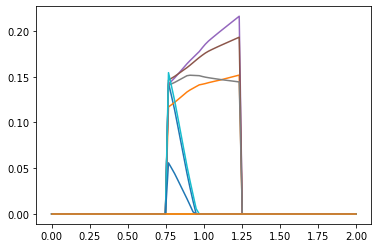

{'train_loss': 0.20194953680038452, 'train_acc': 0.9552980132450332, 'val_loss': 0.4279636740684509, 'val_acc': 0.858, 'test_loss': 0.4214168190956116, 'test_acc': 0.865, 'f1_score': 0.9039881831610044}


In [21]:
min_threshold = 0.75
max_threshold = 1.25
model.analysis.filter_kernel = CutOff(max_val=max_threshold, min_val=min_threshold, kernel=filter_kernel)
model.analysis.filter._kernel = CutOff(max_val=max_threshold, min_val=min_threshold, kernel=filter_kernel)
plot_filter_banks(kernel=model.analysis.filter_kernel)
print(evaluate(model, dataset[0]))

mid_pass_correct_indices = get_correctly_predicted_node_idx(model, 'test', dataset)
with torch.no_grad():
    _, low_att1, low_att2 = model(dataset[0])

Evaluate high pass cutoff

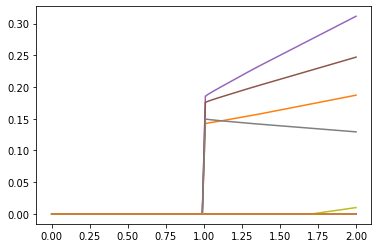

{'train_loss': 0.255296528339386, 'train_acc': 0.9503311258278145, 'val_loss': 0.46159616112709045, 'val_acc': 0.86, 'test_loss': 0.45501333475112915, 'test_acc': 0.858, 'f1_score': 0.899556868537666}


In [22]:

threshold = 1
model.analysis.filter_kernel = CutOff(min_val=threshold, kernel=filter_kernel)
model.analysis.filter._kernel = CutOff(min_val=threshold, kernel=filter_kernel)
plot_filter_banks(kernel=model.analysis.filter_kernel)
print(evaluate(model, dataset[0]))

high_pass_correct_indices = get_correctly_predicted_node_idx(model, 'test', dataset)

with torch.no_grad():
    _, high_att1, high_att2 = model(dataset[0])

Evaluate band pass cutoff

In [23]:
plt.figure(dpi=450)
x = [str(p)+'%' for p in range(20, 110, 10)]
plt.plot(x,
         gcn_noisy_accs,
         linestyle=':',
         zorder=2)
plt.plot(x,
         gat_noisy_accs,
         linestyle='--',
         zorder=2)
plt.plot(x,
         sgc_noisy_accs,
         linestyle='--',
         zorder=2)
plt.plot(x,
         cheb_noisy_accs,
         linestyle=':',
         zorder=2)
plt.plot(x,
         appnp_noisy_accs,
         linestyle='--',
         zorder=2)
plt.plot(x,
         arma_noisy_accs,
         linestyle=':',
         zorder=2)
plt.plot(x,
         model_noisy_accs,
         linewidth=1.5,
         linestyle='-',
         zorder=2)

s1 = plt.scatter(x, gcn_noisy_accs, zorder=1, marker='*')
s2 = plt.scatter(x, gat_noisy_accs, zorder=1, marker="o")
s3 = plt.scatter(x, sgc_noisy_accs, zorder=1, marker='s')
s4 = plt.scatter(x, cheb_noisy_accs, zorder=1, marker='d')
s5 = plt.scatter(x, appnp_noisy_accs, zorder=1, marker='X')
s6 = plt.scatter(x, arma_noisy_accs, zorder=1, marker='v')
s7 = plt.scatter(x, model_noisy_accs, zorder=1, marker='^')
plt.legend((s1, s2, s3, s4, s5, s6, s7), ('GCN', 'GAT', 'SGC', 'Cheby', 'APPNP', 'ARMA', 'Model'))step = 0.25
acc = []
for threshold in torch.arange(0, 1.76, 0.25):
    model.analysis.filter_kernel = CutOff(min_val=threshold, max_val=threshold+step, kernel=filter_kernel)
    model.analysis.filter._kernel = CutOff(min_val=threshold,max_val=threshold+step, kernel=filter_kernel)
#     plot_filter_banks(kernel=model.analysis.filter_kernel)
#     plot_filter_banks(kernel=model.analysis.filter.cheby_eval)
    eval_info = evaluate(model, dataset[0])
    acc.append(eval_info['test_acc'])
print(acc)
    

[0.849, 0.845, 0.845, 0.849, 0.861, 0.846, 0.846, 0.845]


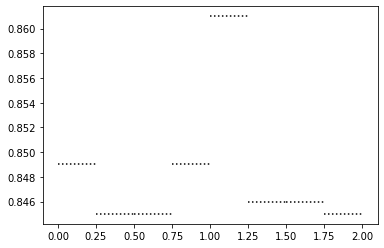

In [24]:
x = torch.arange(0, 1.76, 0.25)
y = acc

plt.hlines(y, x, x+0.25, linestyle=":")

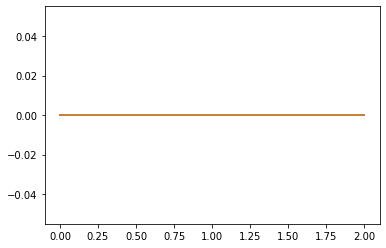

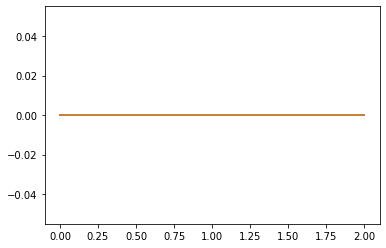

{'train_loss': 0.3553936183452606, 'train_acc': 0.890728476821192, 'val_loss': 0.49297893047332764, 'val_acc': 0.846, 'test_loss': 0.4942516088485718, 'test_acc': 0.844, 'f1_score': 0.8652141802067946}


In [25]:
model.analysis.filter_kernel = CutOff(min_val=2, max_val=0, kernel=filter_kernel)
model.analysis.filter._kernel = CutOff(min_val=2, max_val=0, kernel=filter_kernel)

plot_filter_banks(kernel=model.analysis.filter_kernel)
plot_filter_banks(kernel=model.analysis.filter.cheby_eval)
print(evaluate(model, dataset[0]))

#### Frequency analysis on cutoff

In [26]:
low_not_high_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(low_pass_correct_indices.difference(high_pass_correct_indices))]
high_not_low_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(high_pass_correct_indices.difference(low_pass_correct_indices))]
high_and_low_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(high_pass_correct_indices.intersection(low_pass_correct_indices))]
low_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(low_pass_correct_indices)]
high_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(high_pass_correct_indices)]
mid_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(mid_pass_correct_indices)]


print('Number of node classified correctly by low-pass filters:', len(low_correct_nodes))
print('Number of node classified correctly by high-pass filters:', len(high_correct_nodes))
print('Number of node classified correctly by mid-pass filters:', len(mid_correct_nodes))
print('Number of node classified correctly by low-pass filters but not by high-pass filters:', len(low_not_high_correct_nodes))
print('Number of node classified correctly by high-pass filters but not by low-pass filters:', len(high_not_low_correct_nodes))
print('Number of node classified correctly by both high-pass and low-pass filters:', len(high_and_low_correct_nodes))

Number of node classified correctly by low-pass filters: 852
Number of node classified correctly by high-pass filters: 858
Number of node classified correctly by mid-pass filters: 865
Number of node classified correctly by low-pass filters but not by high-pass filters: 23
Number of node classified correctly by high-pass filters but not by low-pass filters: 29
Number of node classified correctly by both high-pass and low-pass filters: 829


Neighbour distribution of nodes classified correct by high-pass

matching labels in 1st hop: tensor(0.9182)
matching labels in 2st hop: tensor(0.8438)
matching labels in 3rd hop: tensor(0.7233)


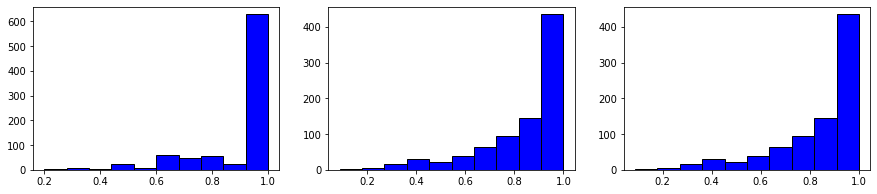

In [27]:
matching_labels_distribution(high_correct_nodes);

Neighbour distribution of nodes classified correct by low-pass

matching labels in 1st hop: tensor(0.9235)
matching labels in 2st hop: tensor(0.8464)
matching labels in 3rd hop: tensor(0.7238)


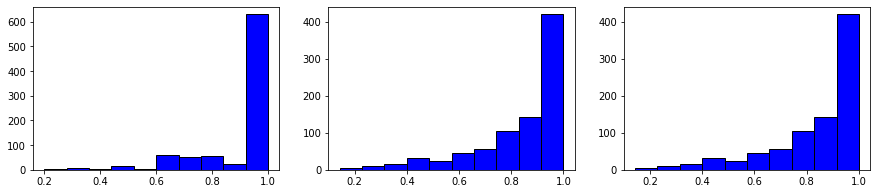

In [28]:
matching_labels_distribution(low_correct_nodes);

Neighbour distribution of nodes classified correct by high-pass but not low pass

matching labels in 1st hop: tensor(0.6295)
matching labels in 2st hop: tensor(0.4725)
matching labels in 3rd hop: tensor(0.4430)


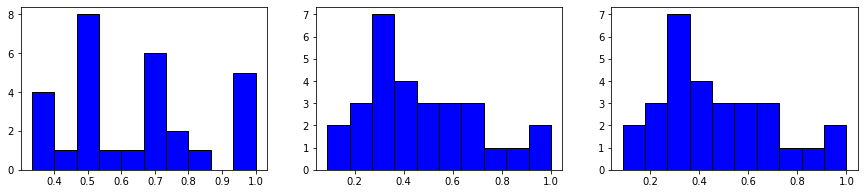

In [29]:
matching_labels_distribution(high_not_low_correct_nodes);

matching labels in 1st hop: tensor(0.7523)
matching labels in 2st hop: tensor(0.4705)
matching labels in 3rd hop: tensor(0.3880)


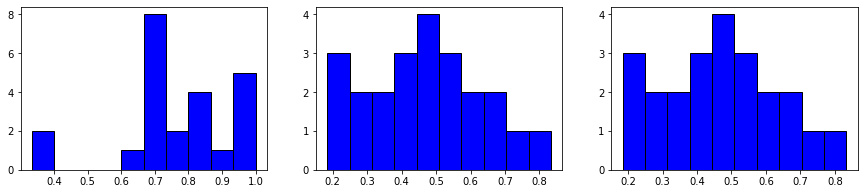

In [30]:
matching_labels_distribution(low_not_high_correct_nodes);

matching labels in 1st hop: tensor(0.9283)
matching labels in 2st hop: tensor(0.8568)
matching labels in 3rd hop: tensor(0.7331)


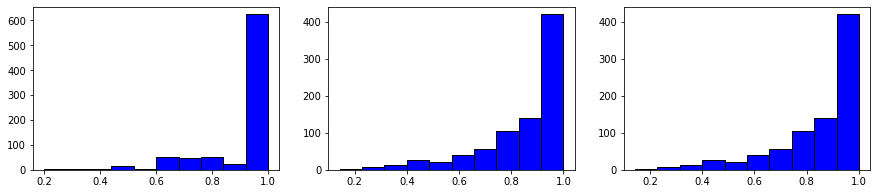

In [31]:
matching_labels_distribution(high_and_low_correct_nodes);

Accuracy on less-similar neighbourhoods

matching labels in 1st hop: tensor(0.8658)
matching labels in 2st hop: tensor(0.7690)
matching labels in 3rd hop: tensor(0.6600)


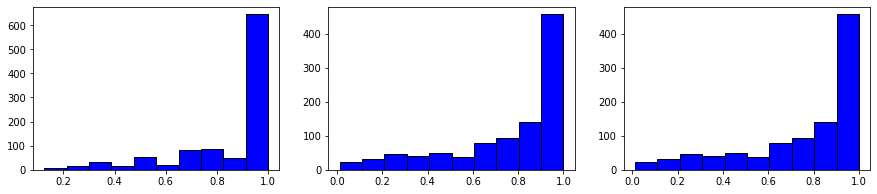

In [25]:
label_distributions = matching_labels_distribution(dataset[0]['test_mask'].nonzero().view(-1));

Draw attentions from high-pass filterbank(s)

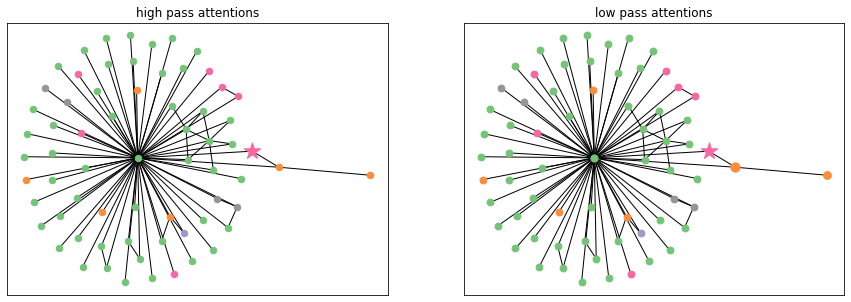

In [33]:
low_attentions = torch.stack(low_att1, 0).sum(0)
high_attentions = torch.stack(high_att1, 0).sum(0)

index = 5
node = high_not_low_correct_nodes[index].item()
# node = low_not_high_correct_nodes[2].item()

Gego = nx.ego_graph(G, node, 2)
nodePos = nx.layout.spring_layout(Gego)

plt.figure(figsize=(15,5))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('high pass attentions')

for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           ax=ax1,
                           nodelist=[n],
                           node_color=[node_colors[dataset[0].y[n].item()](0.5)],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else (high_attentions[node, n]*400).clamp(max=400, min=20))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5, ax=ax1)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('low pass attentions')

for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           ax=ax2,
                           nodelist=[n],
                           node_color=[node_colors[dataset[0].y[n].item()](0.5)],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else (low_attentions[node, n]*400).clamp(max=400, min=20))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5, ax=ax2)

plt.show()

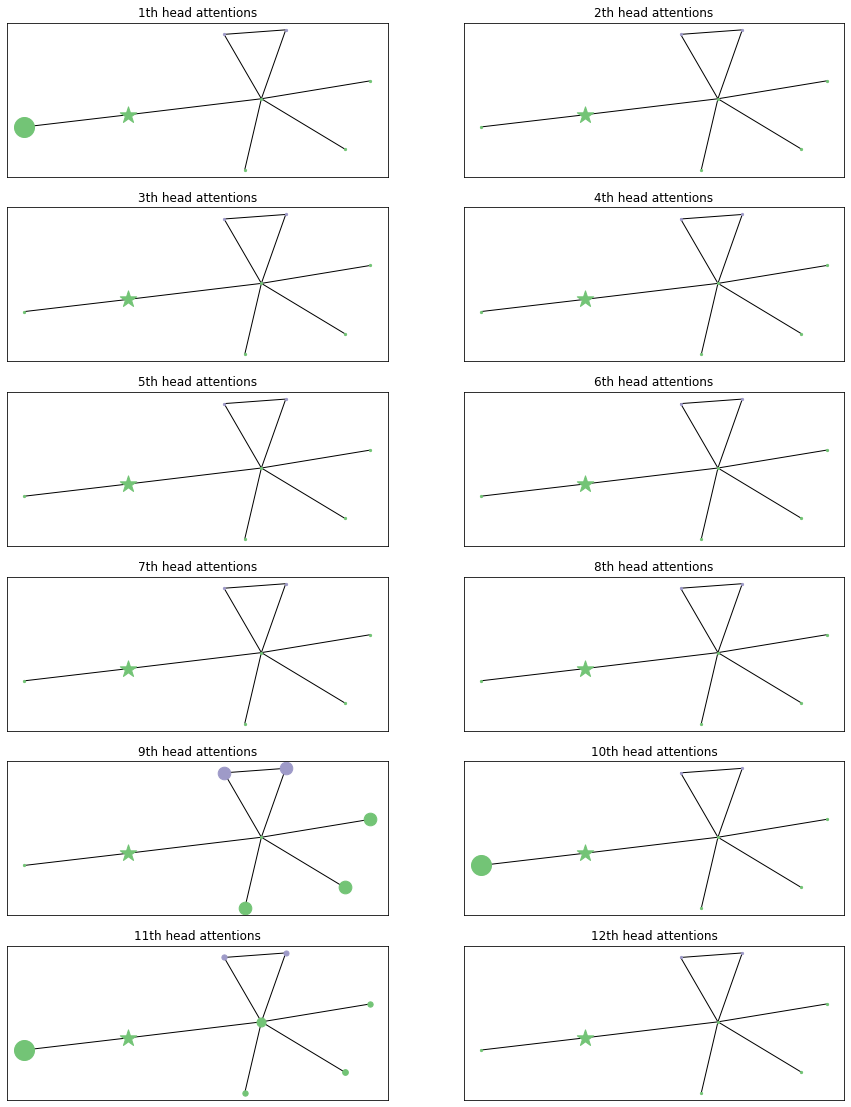

In [160]:
# low_attentions = torch.stack(low_att1, 0).sum(0)
# high_attentions = torch.stack(high_att1, 0).sum(0)

index = 6
node = high_not_low_correct_nodes[index].item()
# node = low_not_high_correct_nodes[index].item()

Gego = nx.ego_graph(G, node, 2)
nodePos = nx.layout.spring_layout(Gego)

plt.figure(figsize=(15,30))

for i in range(heads):
    ax = plt.subplot(9, 2, i+1)
    ax.set_title(str(i+1) + 'th head attentions')

#     print([att1[i][node, n].item() for n in Gego.nodes])
    for n in Gego.nodes:
        nx.draw_networkx_nodes(Gego, nodePos,
                               ax=ax,
                               nodelist=[n],
                               node_color=[node_colors[dataset[0].y[n].item()](0.5)],
                               node_shape="*" if n == node else "o",
                               node_size=300 if n == node else (att1[i][node, n]*1000).clamp(max=400, min=5))
    nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5, ax=ax)
plt.show()

Attended node centrality distribution by frequency bands

In [34]:
# compute all node's centrality
centrality_between = nx.betweenness_centrality(G)
centrality_degree = nx.degree_centrality(G)
centrality_close = nx.closeness_centrality(G)
centrality_eigen = nx.eigenvector_centrality(G)

Degree centrality
high-pass centrality mean: 0.001946732634678483, std: 0.004825516138225794
low-pass centrality mean: 0.001911892439238727, std: 0.004742240533232689

Betweeness centrality
high-pass centrality mean: 0.0037556455936282873, std: 0.01890537515282631
low-pass centrality mean: 0.003549102693796158, std: 0.01852325350046158

Closeness centrality
high-pass centrality mean: 0.129069983959198, std: 0.05664932355284691
low-pass centrality mean: 0.12911447882652283, std: 0.05433988943696022

Eigen centrality
high-pass centrality mean: 0.007259567268192768, std: 0.045945312827825546
low-pass centrality mean: 0.007017639931291342, std: 0.04590621963143349


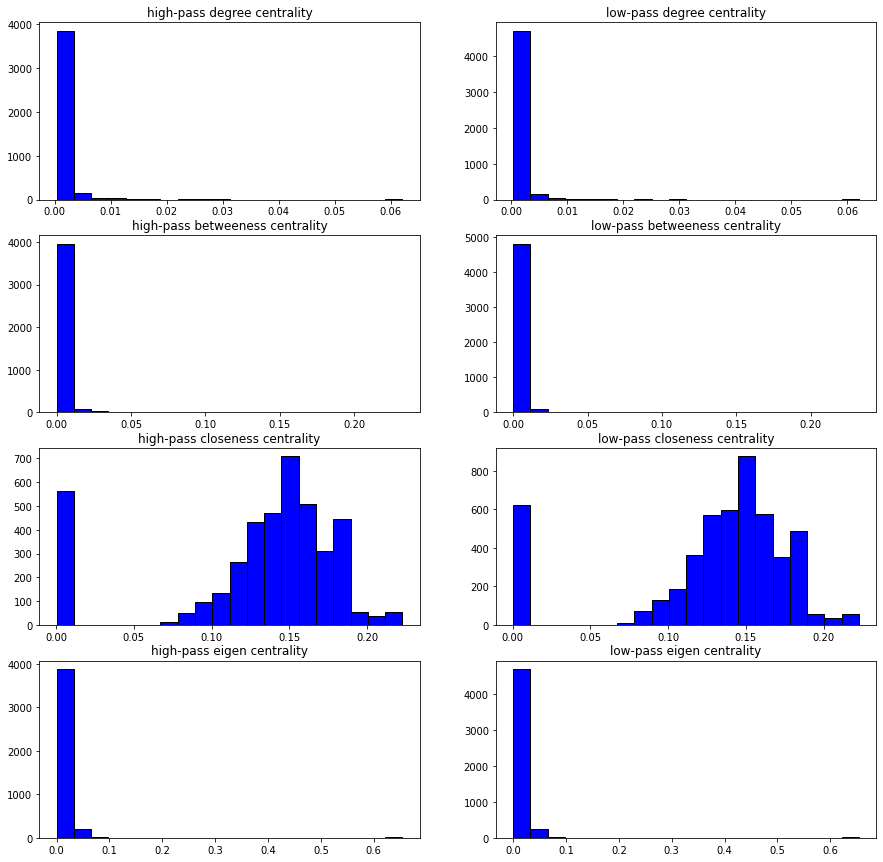

In [35]:
min_att = 1
plt.figure(figsize=(15,15))

print('Degree centrality')
ax1 = plt.subplot(4, 2, 1)
ax1.set_title('high-pass degree centrality')
centralities = torch.tensor([centrality_degree[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

ax2 = plt.subplot(4, 2, 2)
ax2.set_title('low-pass degree centrality')
centralities = torch.tensor([centrality_degree[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

print('\nBetweeness centrality')
ax3 = plt.subplot(4, 2, 3)
ax3.set_title('high-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

ax4 = plt.subplot(4, 2, 4)
ax4.set_title('low-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

print('\nCloseness centrality')
ax5 = plt.subplot(4, 2, 5)
ax5.set_title('high-pass closeness centrality')
centralities = torch.tensor([centrality_close[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

ax6 = plt.subplot(4, 2, 6)
ax6.set_title('low-pass closeness centrality')
centralities = torch.tensor([centrality_close[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

print('\nEigen centrality')
ax7 = plt.subplot(4, 2, 7)
ax7.set_title('high-pass eigen centrality')
centralities = torch.tensor([centrality_eigen[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)


ax8 = plt.subplot(4, 2, 8)
ax8.set_title('low-pass eigen centrality')
centralities = torch.tensor([centrality_eigen[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20);

Attended node page rank distribution by frequency bands

Page Rank
high-pass  page rank mean: 0.000496507073782716, std: 0.0010081384583660767
low-pass page rank mean: 0.0004900067724705858, std: 0.0009905170966653465


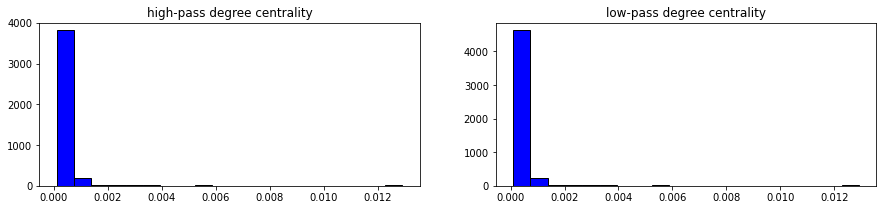

In [36]:
# compute all node's page rank
pr = nx.pagerank(G, alpha=0.9)

min_att = 1
plt.figure(figsize=(15,3))

print('Page Rank')
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('high-pass degree centrality')
prs = torch.tensor([pr[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass  page rank mean: {}, std: {}'.format(prs.mean().item(), prs.std().item()))
plt.hist(prs, color = 'blue', edgecolor = 'black', bins = 20)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('low-pass degree centrality')
prs = torch.tensor([pr[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass page rank mean: {}, std: {}'.format(prs.mean().item(), prs.std().item()))
plt.hist(prs, color = 'blue', edgecolor = 'black', bins = 20);

Distance distribution of attended node

Attended node distance
high-pass node distance mean: 1.8396321535110474, std: 0.4347776770591736
low-pass node distance mean: 1.8396321535110474, std: 0.4347776770591736


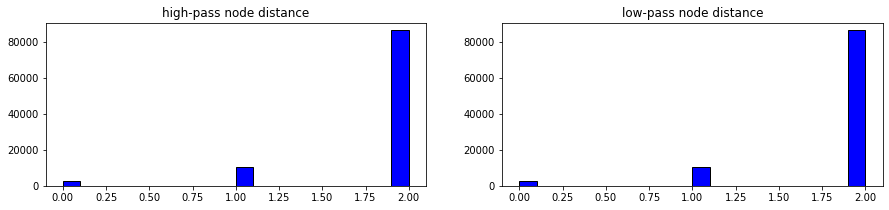

In [37]:
# Compute distances to from a node to its attended nodes
min_att = 0

high_distances = []

masked_high_attenions = high_attentions > min_att
for n1 in G.nodes:
    for n2 in G.nodes:
        if masked_high_attenions[n1, n2]:
            high_distances.append(nx.shortest_path_length(G, n1, n2))

low_distances = []

masked_low_attenions = low_attentions > min_att
for n1 in G.nodes:
    for n2 in G.nodes:
        if masked_low_attenions[n1, n2]:
            low_distances.append(nx.shortest_path_length(G, n1, n2))

            
plt.figure(figsize=(15,3))

print('Attended node distance')
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('high-pass node distance')
distances = torch.tensor(high_distances).float()
print('high-pass node distance mean: {}, std: {}'.format(distances.mean().item(), distances.std().item()))
plt.hist(distances, color = 'blue', edgecolor = 'black', bins = 20)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('low-pass node distance')
distances = torch.tensor(low_distances).float()
print('low-pass node distance mean: {}, std: {}'.format(distances.mean().item(), distances.std().item()))
plt.hist(distances, color = 'blue', edgecolor = 'black', bins = 20);

Re-train model with cutoff

In [38]:
# Similar result as cutoff after training
# from citation import run
#
# model_cutoff = Net(dataset)
#
# max_cutoff=1
# cutoff_kernel = model_cutoff.analysis.filter_kernel
# model_cutoff.analysis.filter_kernel = CutOff(max_val=max_cutoff, kernel=cutoff_kernel)
# model_cutoff.analysis.filter._kernel = CutOff(max_val=max_cutoff, kernel=cutoff_kernel)
#
# plot_filter_banks(kernel=model_cutoff.analysis.filter_kernel)
# print(evaluate(model_cutoff, dataset[0]))
#
# run(dataset, model_cutoff, runs, epochs, lr, weight_decay, patience, None)
#
# plot_filter_banks(kernel=model_cutoff.analysis.filter_kernel)
# print(evaluate(model_cutoff, dataset[0]))


## Evaluate filterbanks

Define kernel to eliminate certain filterbanks

In [35]:
class Elimination(nn.Module):
    def __init__(self, zero_out_indices):
        super(Elimination, self).__init__()
        self.zero_out_indices = zero_out_indices

    def reset_parameters(self):
        pass

    def forward(self, x):
        x = filter_kernel(x)
        x[:, self.zero_out_indices] = torch.zeros(x.shape[0], len(self.zero_out_indices))
        return x

Evaluate each filter bank

In [36]:
all_indices = set(list(range(heads)))
diff= []
for i in range(heads):
    zero_out_filters = list(all_indices.difference({i}))
    model.analysis.filter_kernel = Elimination(zero_out_filters)
    model.analysis.filter._kernel = Elimination(zero_out_filters)
    # plot_filter_banks(kernel=model.analysis.filter_kernel)
    test_acc = evaluate(model, dataset[0])['test_acc']
    diff.append(test_acc - eval_info['test_acc'])
print(' & '.join(['{:.2f}\%'.format(d*100) for d in diff]))

<>:10: DeprecationWarning: invalid escape sequence \%


-2.20\% & -2.20\% & -1.70\% & -2.20\% & -1.70\% & -2.20\% & -2.20\% & -2.20\% & -1.70\% & -1.70\%


Evaluate by eliminating only one filter bank

In [37]:
diff= []
for i in range(heads):
    model.analysis.filter_kernel = Elimination([i])
    model.analysis.filter._kernel = Elimination([i])
    # plot_filter_banks(kernel=model.analysis.filter_kernel)
    test_acc = evaluate(model, dataset[0])['test_acc']
    diff.append(test_acc - eval_info['test_acc'])
print(' & '.join(['{:.2f}\%'.format(d*100) for d in diff]))


0.00\% & 0.00\% & -0.40\% & 0.00\% & -0.40\% & 0.00\% & 0.00\% & 0.00\% & -0.40\% & -0.40\%


Load GAT model

In [7]:
from torch_geometric.nn import GATConv
class GAT(torch.nn.Module):
    def __init__(self, dataset):
        super(GAT, self).__init__()
        self.conv1 = GATConv(
            dataset.num_features,
            8,
            heads=8,
            dropout=0.6)
        self.conv2 = GATConv(
            64,
            dataset.num_classes,
            heads=1,
            concat=False,
            dropout=0.6)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x, (edge_index_1, att_val_1) = self.conv1(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x, (edge_index_2, att_val_2) = self.conv2(x, edge_index, return_attention_weights=True)
        att1 = torch.zeros(data.num_nodes, data.num_nodes, 8)
        att2 = torch.zeros(data.num_nodes, data.num_nodes)
        att1[list(map(lambda x: torch.tensor(x), edge_index_1.tolist()))] = att_val_1
        att2[list(map(lambda x: torch.tensor(x), edge_index_2.tolist()))] = att_val_2.view(-1)
        return F.log_softmax(x, dim=1), att1, att2

gat = GAT(dataset)
gat.load_state_dict(torch.load('./model/best_{}_gat.pkl'.format(dataset_name)))
gat_correct_indices = get_correctly_predicted_node_idx(gat, 'test', dataset)

with torch.no_grad():
    _, gat_att1, gat_att2 = gat(dataset[0])
evaluate(gat, dataset[0])

{'train_loss': 0.5066099166870117,
 'train_acc': 0.9213576158940397,
 'train_micro_f1_score': 0.9213576158940397,
 'train_macro_f1_score': 0.916870618394878,
 'val_loss': 0.6066293120384216,
 'val_acc': 0.874,
 'val_micro_f1_score': 0.874,
 'val_macro_f1_score': 0.8725733728196404,
 'test_loss': 0.6136246919631958,
 'test_acc': 0.88,
 'test_micro_f1_score': 0.88,
 'test_macro_f1_score': 0.8690932025503308}

In [8]:
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):
    def __init__(self, dataset):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 64)
        self.conv2 = GCNConv(64, dataset.num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1), None
    
gcn = GCN(dataset)
gcn.load_state_dict(torch.load('./model/best_{}_gcn.pkl'.format(dataset_name)))
gcn_correct_indices = get_correctly_predicted_node_idx(gcn, 'test', dataset)

evaluate(gcn, dataset[0])

{'train_loss': 0.3452123701572418,
 'train_acc': 0.9387417218543046,
 'train_micro_f1_score': 0.9387417218543046,
 'train_macro_f1_score': 0.9349504890302925,
 'val_loss': 0.4940210282802582,
 'val_acc': 0.882,
 'val_micro_f1_score': 0.882,
 'val_macro_f1_score': 0.873138172217738,
 'test_loss': 0.49700257182121277,
 'test_acc': 0.873,
 'test_micro_f1_score': 0.8729999999999999,
 'test_macro_f1_score': 0.8592602872654577}

In [9]:
from torch_geometric.nn import SGConv

class SGC(torch.nn.Module):
    def __init__(self, dataset):
        super(SGC, self).__init__()
        self.conv1 = SGConv(
            dataset.num_features, dataset.num_classes, K=2, cached=True)

    def reset_parameters(self):
        self.conv1.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return F.log_softmax(x, dim=1), None

dataset_unnormalized = get_dataset(dataset_name, False, edge_dropout=edge_dropout,
                                node_feature_dropout=node_feature_dropout)
sgc = SGC(dataset_unnormalized)
sgc.load_state_dict(torch.load('./model/best_{}_sgc.pkl'.format(dataset_name)))
sgc_correct_indices = get_correctly_predicted_node_idx(sgc, 'test', dataset_unnormalized)

evaluate(sgc, dataset_unnormalized[0])

{'train_loss': 0.2252436727285385,
 'train_acc': 0.9445364238410596,
 'train_micro_f1_score': 0.9445364238410596,
 'train_macro_f1_score': 0.9397726197669088,
 'val_loss': 0.41528862714767456,
 'val_acc': 0.888,
 'val_micro_f1_score': 0.888,
 'val_macro_f1_score': 0.8822774011709049,
 'test_loss': 0.4060928225517273,
 'test_acc': 0.875,
 'test_micro_f1_score': 0.875,
 'test_macro_f1_score': 0.8641416845135953}

In [10]:
from torch_geometric.nn import ChebConv


class Cheb(torch.nn.Module):
    def __init__(self, dataset):
        super(Cheb, self).__init__()
        self.conv1 = ChebConv(dataset.num_features, 16, 3)
        self.conv2 = ChebConv(16, dataset.num_classes, 3)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1), None
    
cheb = Cheb(dataset)
cheb.load_state_dict(torch.load('./model/best_{}_cheb.pkl'.format(dataset_name)))
cheb_correct_indices = get_correctly_predicted_node_idx(cheb, 'test', dataset)

evaluate(cheb, dataset[0])

{'train_loss': 0.20055268704891205,
 'train_acc': 0.9685430463576159,
 'train_micro_f1_score': 0.9685430463576159,
 'train_macro_f1_score': 0.9670177264695791,
 'val_loss': 0.4415293335914612,
 'val_acc': 0.89,
 'val_micro_f1_score': 0.89,
 'val_macro_f1_score': 0.8835842995020372,
 'test_loss': 0.42450353503227234,
 'test_acc': 0.885,
 'test_micro_f1_score': 0.885,
 'test_macro_f1_score': 0.8722198835446882}

In [11]:
from torch_geometric.nn import APPNP
from torch.nn import Linear

class Appnp(torch.nn.Module):
    def __init__(self, dataset):
        super(Appnp, self).__init__()
        self.lin1 = Linear(dataset.num_features, 64)
        self.lin2 = Linear(64, dataset.num_classes)
        self.prop1 = APPNP(10, 0.1)

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.prop1(x, edge_index)
        return F.log_softmax(x, dim=1), None
    
appnp = Appnp(dataset)
appnp.load_state_dict(torch.load('./model/best_{}_appnp.pkl'.format(dataset_name)))
appnp_correct_indices = get_correctly_predicted_node_idx(appnp, 'test', dataset)

evaluate(appnp, dataset[0])

{'train_loss': 0.45162782073020935,
 'train_acc': 0.9089403973509934,
 'train_micro_f1_score': 0.9089403973509934,
 'train_macro_f1_score': 0.9002440525322396,
 'val_loss': 0.5506687760353088,
 'val_acc': 0.886,
 'val_micro_f1_score': 0.886,
 'val_macro_f1_score': 0.8851792077874838,
 'test_loss': 0.543052077293396,
 'test_acc': 0.879,
 'test_micro_f1_score': 0.879,
 'test_macro_f1_score': 0.8639003182790634}

In [12]:
from torch_geometric.nn import ARMAConv

class ARMA(torch.nn.Module):
    def __init__(self, dataset):
        super(ARMA, self).__init__()
        self.conv1 = ARMAConv(
            dataset.num_features,
            16,
            1,
            1,
            False,
            dropout=0.75)
        self.conv2 = ARMAConv(
            16,
            dataset.num_classes,
            1,
            1,
            False,
            dropout=0.75)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1), None
    
arma = ARMA(dataset)
arma.load_state_dict(torch.load('./model/best_{}_arma.pkl'.format(dataset_name)))
arma_correct_indices = get_correctly_predicted_node_idx(arma, 'test', dataset)

evaluate(arma, dataset[0])

{'train_loss': 0.2886655330657959,
 'train_acc': 0.9461920529801324,
 'train_micro_f1_score': 0.9461920529801324,
 'train_macro_f1_score': 0.9424373973387201,
 'val_loss': 0.4775325655937195,
 'val_acc': 0.886,
 'val_micro_f1_score': 0.886,
 'val_macro_f1_score': 0.8798463319927129,
 'test_loss': 0.4878349006175995,
 'test_acc': 0.881,
 'test_micro_f1_score': 0.881,
 'test_macro_f1_score': 0.8677623779019294}

In [28]:
from random import choice
from collections import Counter
from scipy.sparse import coo_matrix
import networkx as nx


def multimode(eles, num_classes):
    res = []
    if(len(eles) == 0):
        eles = list(range(num_classes))
    counter = Counter(eles)
    temp = counter.most_common(1)[0][1]
    for ele in eles:
      if eles.count(ele) == temp:
        res.append(ele)
    return list(set(res))

class MajorityVote(torch.nn.Module):
    def __init__(self, dataset):
        super(MajorityVote, self).__init__()
        self.num_classes = dataset.num_classes
        adj = coo_matrix(
            (np.ones(dataset[0].num_edges),
             (dataset[0].edge_index[0].numpy(), dataset[0].edge_index[1].numpy())),
            shape=(dataset[0].num_nodes, dataset[0].num_nodes))
        self.G = nx.Graph(adj)
        
    def forward(self, data):
        train_nodes = set(data.train_mask.nonzero().view(-1).tolist())

        logits = []
        for n in range(data.num_nodes):
            hop_1_neighbours = set(nx.ego_graph(self.G, n, 1).nodes())
            hop_1_labels = data.y[list(hop_1_neighbours)]
            label = choice(multimode(hop_1_labels.tolist(), self.num_classes))
            logits.append(F.one_hot(torch.tensor(label), self.num_classes).float())
        return torch.stack(logits, 0), None
    
majority_vote = MajorityVote(dataset)
# arma_correct_indices = get_correctly_predicted_node_idx(arma, 'test', dataset)

evaluate(majority_vote, dataset[0])

{'train_loss': -0.9304635524749756,
 'train_acc': 0.9304635761589404,
 'val_loss': -0.9359999895095825,
 'val_acc': 0.936,
 'test_loss': -0.925000011920929,
 'test_acc': 0.925,
 'f1_score': 0.9294682422451994}

In [29]:
np.sum([torch.prod(torch.tensor(p.shape)) for p in list(gat.parameters())])

92373

In [31]:
np.sum([torch.prod(torch.tensor(p.shape)) for p in list(model.parameters())])

93340

In [30]:
def cal_acc_in_noisy_neighbourhood(m, dataset):
    m.eval()
    accs = []
    with torch.no_grad():
        logits  = m(dataset[0])[0]
    for p in torch.arange(0.2, 1.1, 0.1):
        dissimilar_neighbhour_nodes_mask = dataset[0]['test_mask'].clone()
        dissimilar_neighbhour_nodes_mask[dissimilar_neighbhour_nodes_mask] = (torch.tensor(label_distributions[0]) <= p)
        mask = dissimilar_neighbhour_nodes_mask
        pred = logits[mask].max(1)[1]
        accs.append(pred.eq(dataset[0].y[mask]).sum().item() / mask.sum().item())
    return accs

# Try to get some standard deviations 

In [32]:
model_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(model, dataset))
gat_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(gat, dataset))
gcn_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(gcn, dataset))
sgc_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(sgc, dataset_unnormalized))
cheb_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(cheb, dataset))
appnp_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(appnp, dataset))
arma_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(arma, dataset))
majority_vote_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(majority_vote, dataset))

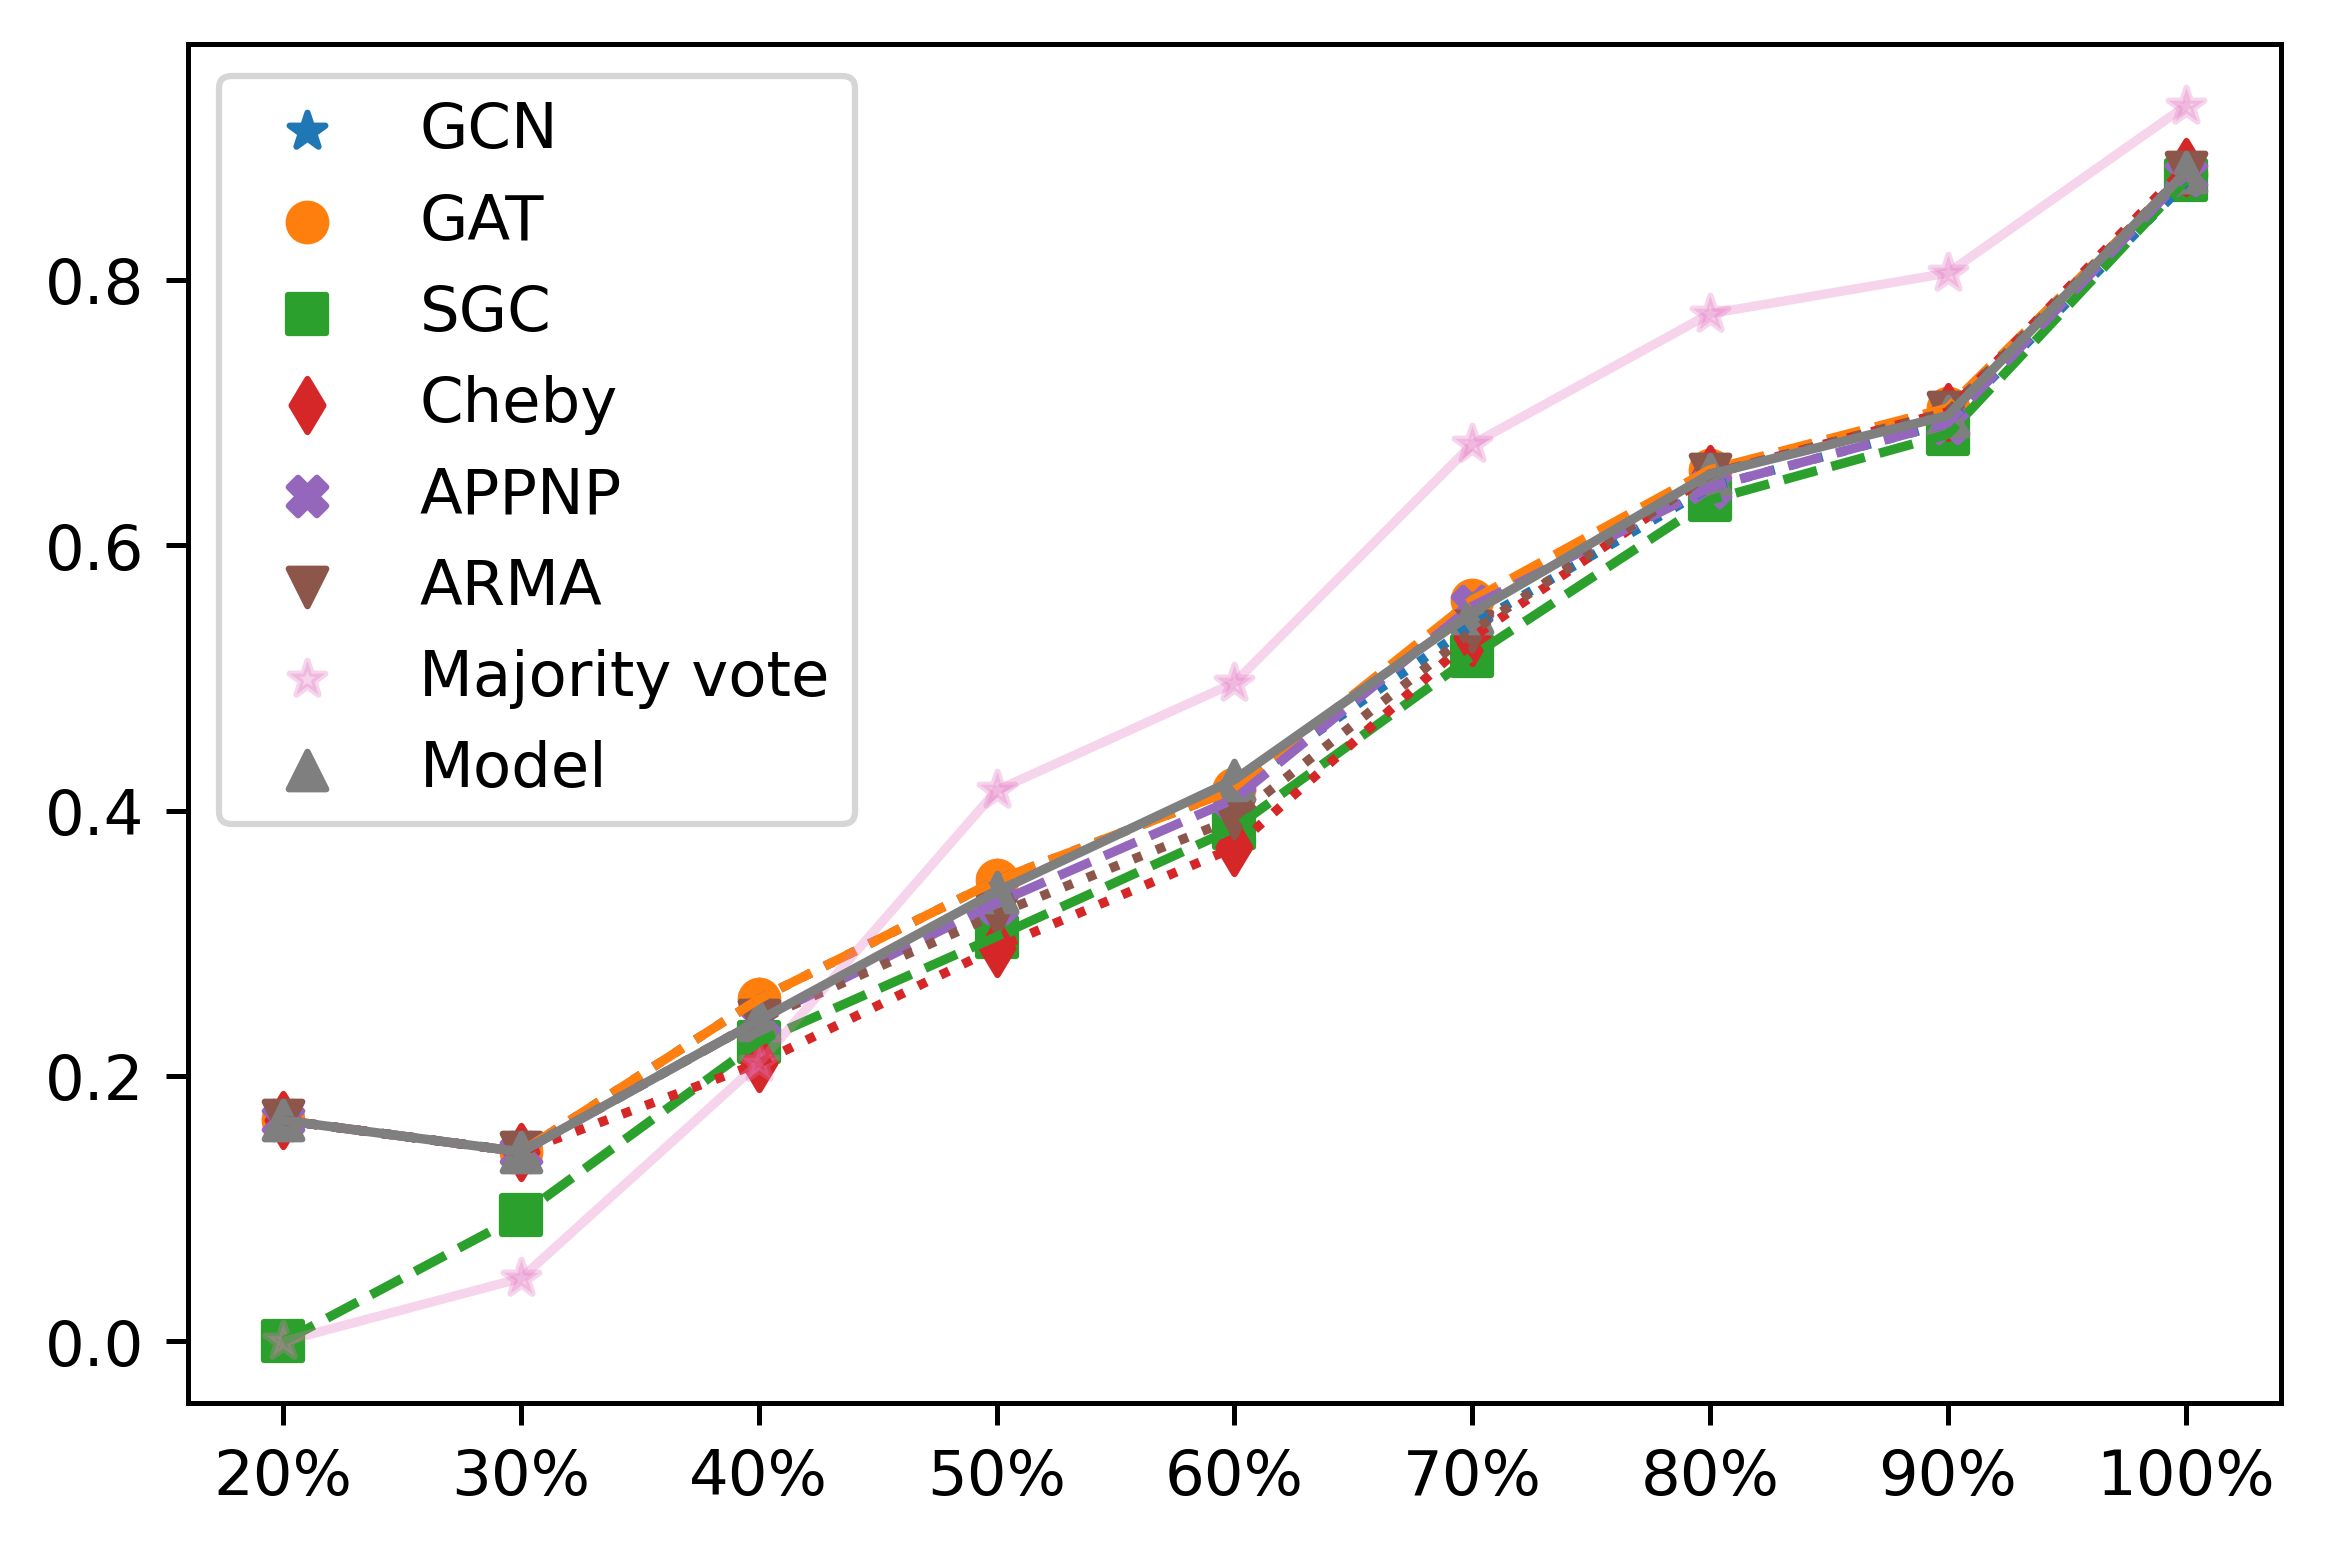

In [33]:
plt.figure(dpi=450)
x = [str(p)+'%' for p in range(20, 110, 10)]
plt.plot(x,
         gcn_noisy_accs,
         linestyle=':',
         zorder=2)
plt.plot(x,
         gat_noisy_accs,
         linestyle='--',
         zorder=2)
plt.plot(x,
         sgc_noisy_accs,
         linestyle='--',
         zorder=2)
plt.plot(x,
         cheb_noisy_accs,
         linestyle=':',
         zorder=2)
plt.plot(x,
         appnp_noisy_accs,
         linestyle='--',
         zorder=2)
plt.plot(x,
         arma_noisy_accs,
         linestyle=':',
         zorder=2)
plt.plot(x,
         majority_vote_noisy_accs,
         linestyle='-',
#          linewidth=0.5,
         alpha=0.3,
         zorder=2)
plt.plot(x,
         model_noisy_accs,
         linewidth=1.5,
         linestyle='-',
         zorder=2)

s1 = plt.scatter(x, gcn_noisy_accs, zorder=1, marker='*')
s2 = plt.scatter(x, gat_noisy_accs, zorder=1, marker="o")
s3 = plt.scatter(x, sgc_noisy_accs, zorder=1, marker='s')
s4 = plt.scatter(x, cheb_noisy_accs, zorder=1, marker='d')
s5 = plt.scatter(x, appnp_noisy_accs, zorder=1, marker='X')
s6 = plt.scatter(x, arma_noisy_accs, zorder=1, marker='v')
s7 = plt.scatter(x, majority_vote_noisy_accs, zorder=1, marker='*', alpha=0.3)
s8 = plt.scatter(x, model_noisy_accs, zorder=1, marker='^')
plt.legend((s1, s2, s3, s4, s5, s6, s7, s8), ('GCN', 'GAT', 'SGC', 'Cheby', 'APPNP', 'ARMA', 'Majority vote', 'Model'))

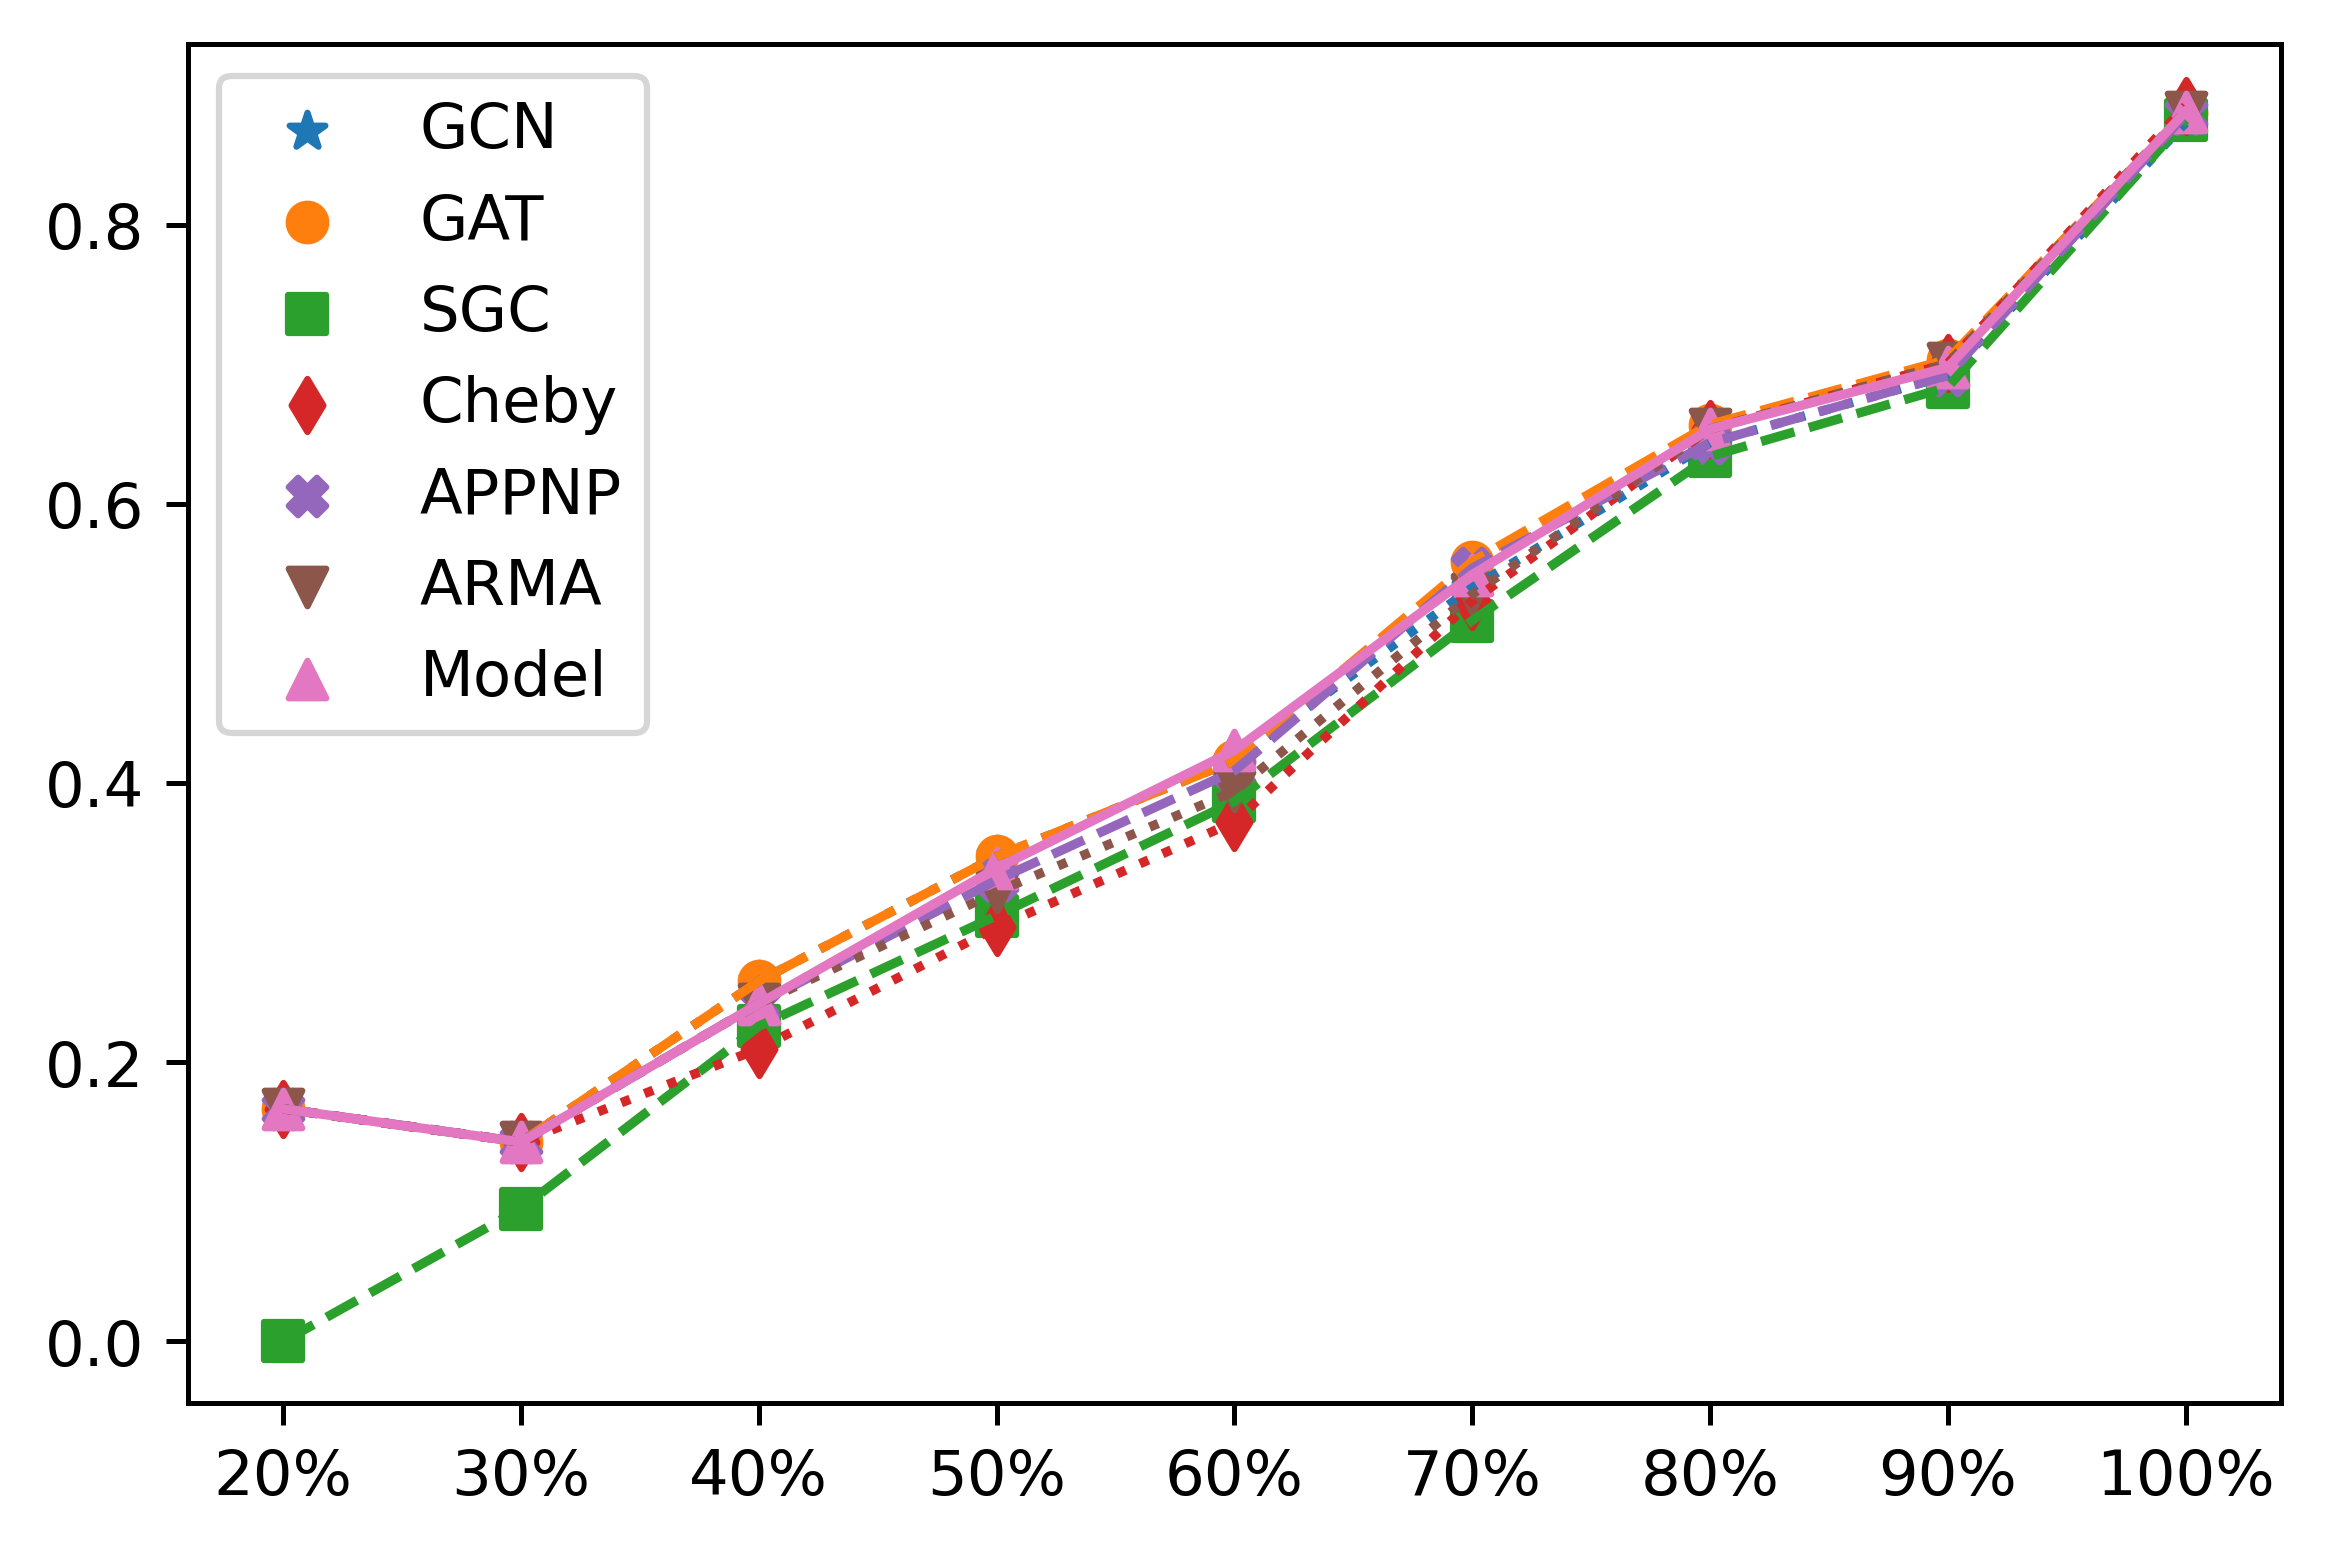

In [34]:
plt.figure(dpi=450)
x = [str(p)+'%' for p in range(20, 110, 10)]
plt.plot(x,
         gcn_noisy_accs,
         linestyle=':',
         zorder=2)
plt.plot(x,
         gat_noisy_accs,
         linestyle='--',
         zorder=2)
plt.plot(x,
         sgc_noisy_accs,
         linestyle='--',
         zorder=2)
plt.plot(x,
         cheb_noisy_accs,
         linestyle=':',
         zorder=2)
plt.plot(x,
         appnp_noisy_accs,
         linestyle='--',
         zorder=2)
plt.plot(x,
         arma_noisy_accs,
         linestyle=':',
         zorder=2)
plt.plot(x,
         model_noisy_accs,
         linewidth=1.5,
         linestyle='-',
         zorder=2)

s1 = plt.scatter(x, gcn_noisy_accs, zorder=1, marker='*')
s2 = plt.scatter(x, gat_noisy_accs, zorder=1, marker="o")
s3 = plt.scatter(x, sgc_noisy_accs, zorder=1, marker='s')
s4 = plt.scatter(x, cheb_noisy_accs, zorder=1, marker='d')
s5 = plt.scatter(x, appnp_noisy_accs, zorder=1, marker='X')
s6 = plt.scatter(x, arma_noisy_accs, zorder=1, marker='v')
s7 = plt.scatter(x, model_noisy_accs, zorder=1, marker='^')
plt.legend((s1, s2, s3, s4, s5, s6, s7), ('GCN', 'GAT', 'SGC', 'Cheby', 'APPNP', 'ARMA', 'Model'))

Comparison with GAT

In [75]:
model_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(model_correct_indices)]
gat_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(gat_correct_indices)]
model_not_gat_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(model_correct_indices.difference(gat_correct_indices))]
model_and_gat_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(model_correct_indices.intersection(gat_correct_indices))]
gat_not_model_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(gat_correct_indices.difference(model_correct_indices))]
gat_and_model_incorrect_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(set(dataset[0].y[dataset[0]['test_mask']].nonzero().view(-1).tolist()).difference(model_correct_indices).difference(gat_correct_indices))]
print('Number of node classified correctly by our model:', len(model_correct_nodes))
print('Number of node classified correctly by GAT:', len(gat_correct_nodes))
print('Number of node classified correctly by our model but not by GAT:', len(model_not_gat_correct_nodes))
print('Number of node classified correctly by both GAT and our model:', len(model_and_gat_correct_nodes))
print('Number of node classified correctly by GAT but not by our model:', len(gat_not_model_correct_nodes))
print('Number of node classified incorrectly by GAT and our model:', len(gat_and_model_incorrect_nodes))


Number of node classified correctly by our model: 875
Number of node classified correctly by GAT: 880
Number of node classified correctly by our model but not by GAT: 19
Number of node classified correctly by both GAT and our model: 856
Number of node classified correctly by GAT but not by our model: 24
Number of node classified incorrectly by GAT and our model: 84


In [76]:
gat_att1_sum = gat_att1.sum(dim=2)

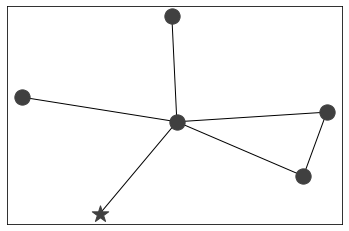

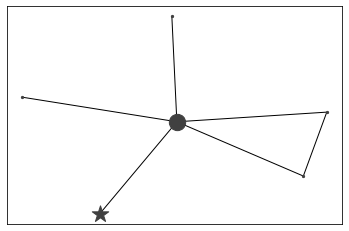

In [77]:
node = model_not_gat_correct_nodes[1].item()
Gego = nx.ego_graph(G, node, 2)
nodePos = nx.layout.spring_layout(Gego)
plt.figure()
for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           nodelist=[n],
                           node_color=[node_colors[dataset[0].y[n].item()](0.8)],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else (model_att1_sum[node, n]*200).clamp(max=400, min=5))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5)


plt.figure()
for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           nodelist=[n],
                           node_color=[node_colors[dataset[0].y[n].item()](0.8)],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else (gat_att1_sum[node, n]*200).clamp(max=400, min=5))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5)



Label distribution of nodes classified correctly by our model


Betweeness centrality
high-pass centrality mean: 0.0031025800853967667, std: 0.008951541967689991


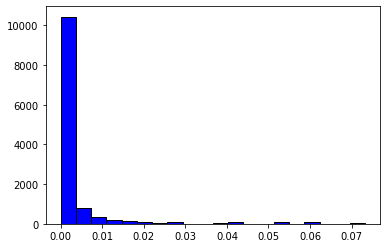

In [199]:
print('\nBetweeness centrality')
ax3 = plt.subplot(1, 1, 1)
# ax3.set_title('high-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (gat_att1_sum).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20);


Betweeness centrality
high-pass centrality mean: 0.003282387275248766, std: 0.008437315002083778


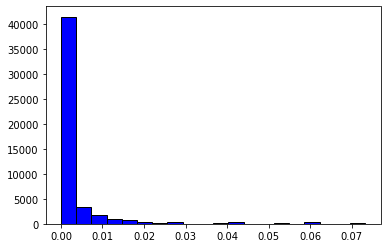

In [200]:
print('\nBetweeness centrality')
ax3 = plt.subplot(1, 1, 1)
# ax3.set_title('high-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (model_att1_sum).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20);

matching labels in 1st hop: tensor(0.8937)
matching labels in 2st hop: tensor(0.8390)
matching labels in 3rd hop: tensor(0.7911)


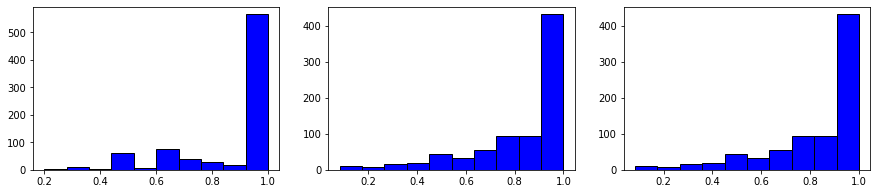

In [202]:
matching_labels_distribution(model_correct_nodes);

In [221]:
min_att = 0.2

Label distribution of nodes classified correctly by our model


Betweeness centrality
high-pass centrality mean: 0.0024233979638665915, std: 0.0065828170627355576


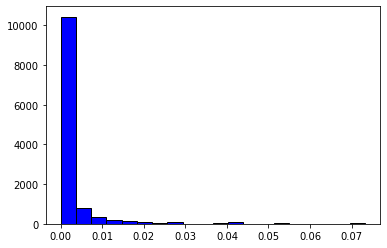

In [222]:
print('\nBetweeness centrality')
ax3 = plt.subplot(1, 1, 1)
# ax3.set_title('high-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (gat_att1_sum > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20);


Betweeness centrality
high-pass centrality mean: 0.002925171982496977, std: 0.007751181721687317


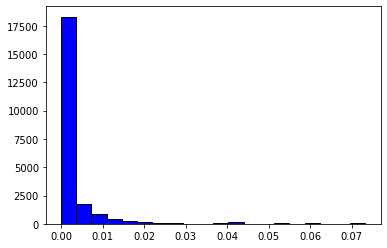

In [223]:
print('\nBetweeness centrality')
ax3 = plt.subplot(1, 1, 1)
# ax3.set_title('high-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (model_att1_sum > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20);

matching labels in 1st hop: tensor(0.8937)
matching labels in 2st hop: tensor(0.8390)
matching labels in 3rd hop: tensor(0.7911)


([tensor(0.6000),
  tensor(0.5714),
  tensor(0.6667),
  tensor(0.9167),
  tensor(0.5000),
  tensor(1.),
  tensor(1.),
  tensor(0.7143),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(0.6667),
  tensor(1.),
  tensor(1.),
  tensor(0.5000),
  tensor(0.5714),
  tensor(1.),
  tensor(0.6250),
  tensor(1.),
  tensor(1.),
  tensor(0.7500),
  tensor(0.7143),
  tensor(1.),
  tensor(1.),
  tensor(0.5000),
  tensor(0.7500),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(0.5000),
  tensor(0.6667),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(0.6667),
  tensor(1.),
  tensor(1.),
  tensor(0.5000),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(0.8462),
  tensor(0.8333),
  tensor(0.8333),
  tensor(1.),
  tensor(0.3333),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(0.6250),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(0.6667),
  tensor(0.7500),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(0.8000),
  tensor(1.),


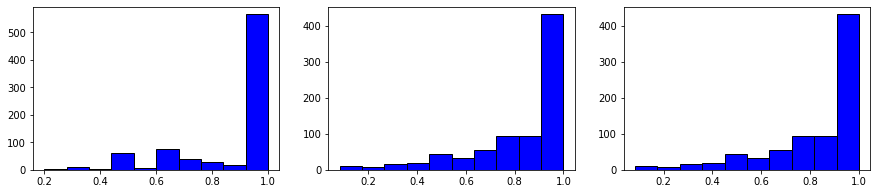

In [224]:
matching_labels_distribution(model_correct_nodes);

Label distribution of nodes classified correctly by GAT

matching labels in 1st hop: tensor(0.9083)
matching labels in 2st hop: tensor(0.8623)
matching labels in 3rd hop: tensor(0.8197)


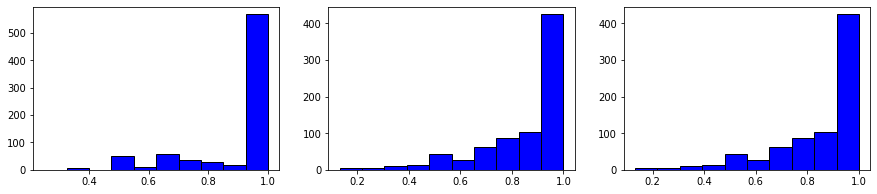

In [225]:
matching_labels_distribution(gat_correct_nodes);

Label distribution of nodes classified correctly by our model but not by GAT

matching labels in 1st hop: tensor(0.6593)
matching labels in 2st hop: tensor(0.4637)
matching labels in 3rd hop: tensor(0.3674)


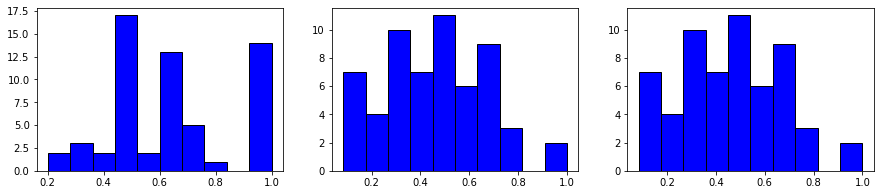

In [226]:
matching_labels_distribution(model_not_gat_correct_nodes);

Label distribution of nodes classified correctly our model and by GAT

matching labels in 1st hop: tensor(0.9122)
matching labels in 2st hop: tensor(0.8687)
matching labels in 3rd hop: tensor(0.8246)


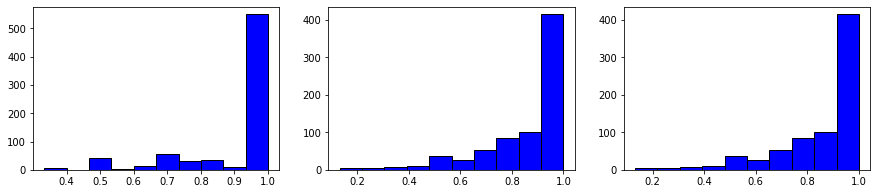

In [227]:
matching_labels_distribution(model_and_gat_correct_nodes);

Label distribution of nodes classified correctly GAT but not by our model

In [ ]:
matching_labels_distribution(gat_not_model_correct_nodes)

Label distribution of nodes classified incorrectly by both GAT and our model

In [ ]:
matching_labels_distribution(gat_and_model_incorrect_nodes)